# FYP - IllustrisTNG Lens Modelling

Lens Infomation:

No subhalos 

No shear - but still need to try shear

1st - Get the Position and position uncertainty 

Run positon constraint models

lambda CDM Cosmology

SIE 
NFW
POW
CORE SIE
EINASTO



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from error_propagation import Complex
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry
from photutils.psf import make_psf_model_image, CircularGaussianPSF, GaussianPSF, MoffatPSF
from tqdm import tqdm
import emcee
norm = ImageNormalize(stretch=SqrtStretch())

# Initial Processing

In [58]:
image_file = "oldfiles/Rommulus_Mock_i2_SNIa_z1_cusp.fits"
# image_file = "Rommulus_withLight_Mock_i2_SNIa_z1_cusp.fits"

In [63]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: oldfiles/Rommulus_Mock_i2_SNIa_z1_cusp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (125, 125)   float64   


In [64]:
hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  125                                                  
NAXIS2  =                  125                                                  
EXTEND  =                    T                                                  
BUNIT   = 'electron/s'                                                          
TELESCOP= 'HST     '                                                            
INSTRUME= 'WFC3    '                                                            
FILTER  = 'SDSS-r (F625W)'                                                      
PHOTFLAM=              1.2E-19 / erg/cm**2/AA/electron                          
WL_PIVOT=               6266.2 / AA                                             
EXPT    =                  6

In [65]:
exposure = hdu_list[0].header['EXPT']
flux_density = hdu_list[0].header['PHOTFLAM']
flux_wavelength = hdu_list[0].header['WL_PIVOT']
pix_size = hdu_list[0].header['PIXSIZE']
z_l = hdu_list[0].header['Z_LENS']
z_s = hdu_list[0].header['Z_SOURCE']
gain = hdu_list[0].header['GAIN']
rdnoise = hdu_list[0].header['READNSE']
print('Exposure:', exposure)
print('Flux Density:', flux_density)
print('Flux Wavelength:', flux_wavelength)
print('Pixel Size:', pix_size)
print('Lens Redshift:', z_l)
print('Source Redshift:', z_s)
print('Gain:', gain)
print('Read Noise:', rdnoise)

Exposure: 600
Flux Density: 1.2e-19
Flux Wavelength: 6266.2
Pixel Size: 0.04
Lens Redshift: 0.261343256161012
Source Redshift: 1
Gain: 1.6
Read Noise: 3.08


In [66]:
image_data = hdu_list[0].data

In [67]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(125, 125)


In [68]:
hdu_list.close()

(0.0, 125.0)

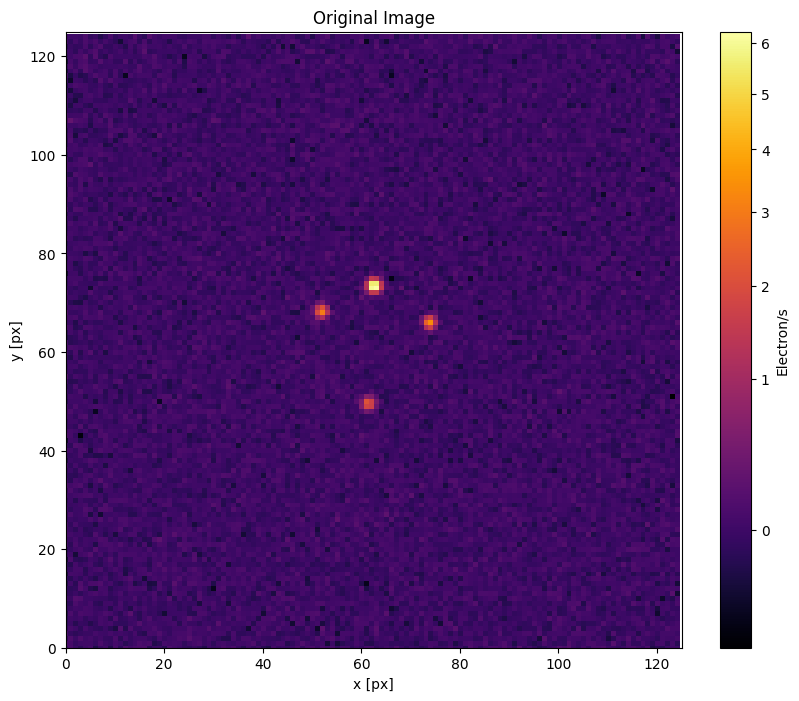

In [71]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(image_data, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [72]:
df = pd.DataFrame(columns=['x', 'y', 'counts'])

In [73]:
# Convert to dataframe (more usable)
df['counts'] = image_data.flatten()
df['x'] = np.tile(np.arange(0, image_data.shape[0]), image_data.shape[1]) + 1
df['y'] = np.repeat(np.arange(0, image_data.shape[1]), image_data.shape[0]) + 1

In [74]:
df

x    y    counts
0        1    1 -0.015840
1        2    1  0.075138
2        3    1 -0.018375
3        4    1 -0.082721
4        5    1  0.002673
...    ...  ...       ...
15620  121  125 -0.158428
15621  122  125  0.076475
15622  123  125 -0.005410
15623  124  125  0.013427
15624  125  125  0.051500

[15625 rows x 3 columns]

In [75]:
df['counts'] = df['counts'] * exposure

Text(0.5, 1.0, 'Original Image')

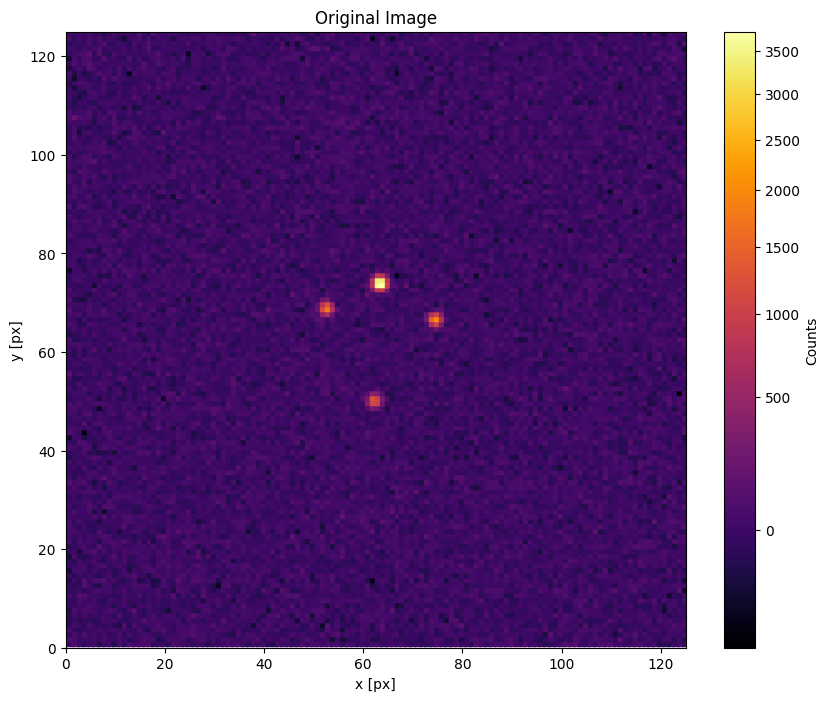

In [76]:
# Original image as scatter plot 
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(10,8))
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.title('Original Image')


Text(0.5, 0.98, 'MCMC Fit Position with Source Offset')

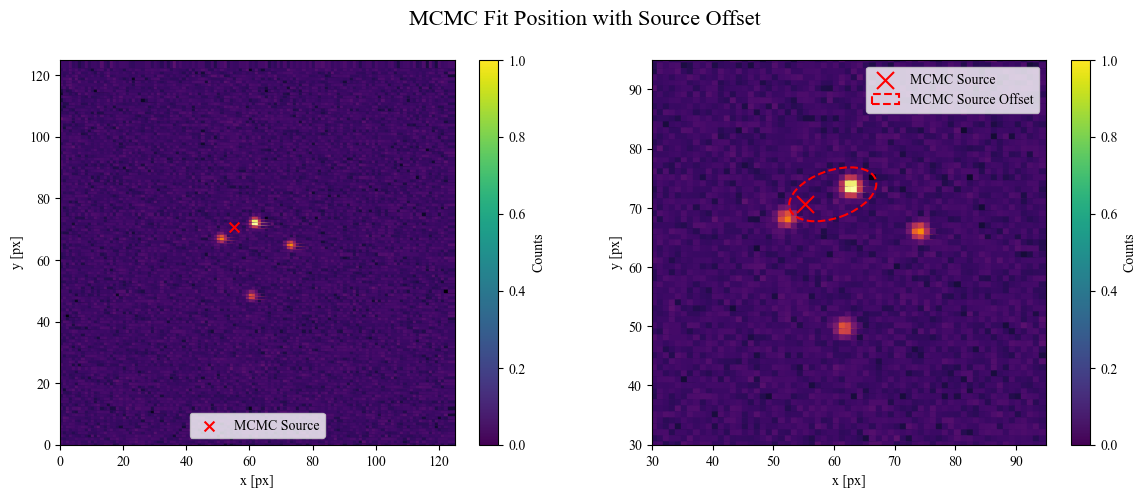

In [77]:
# Add an ellipse to the first subplot
ellipse1 = Ellipse((59.8, 72.2751), width=15, height=8, angle=20, edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='MCMC Source Offset')
plt.rc('font', family='Times New Roman')

# Original image as scatter plot 
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=100, marker='s', norm=norm)
plt.scatter(55.271, 70.5751, s=50, marker='x', color='r', label='MCMC Source')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=100, marker='s', norm=norm)
plt.scatter(55.271, 70.5751, s=150, marker='x', color='r', label='MCMC Source')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(30, 95)
plt.ylim(30, 95)
plt.colorbar(label='Counts')
plt.gca().add_artist(ellipse1)
plt.legend()
plt.suptitle('MCMC Fit Position with Source Offset', font = 'Times New Roman', fontsize=16)


In [44]:
# Mean + Std of counts for threshold calculation
mean_counts = np.mean(df['counts'].astype(float))
std_counts = np.std(df['counts'])
print('Mean Counts:', mean_counts)
print('Std Counts:', std_counts)

Mean Counts: 0.018592918483848142
Std Counts: 42.20613797102471


In [52]:
# Signal Detection (3 sigma threshold)
threshold = mean_counts + 3 * std_counts

df['detection'] = df['counts'] > threshold

In [53]:
df

x     y      counts  detection
0           1     1  -45.479975      False
1           2     1   65.996500      False
2           3     1  -66.676256      False
3           4     1   15.617700      False
4           5     1   26.613204      False
...       ...   ...         ...        ...
1079516  1035  1039  -40.894140      False
1079517  1036  1039  -23.533796      False
1079518  1037  1039  -11.223896      False
1079519  1038  1039  -15.043191      False
1079520  1039  1039  105.752672      False

[1079521 rows x 4 columns]

In [54]:
mask = pd.DataFrame(columns=['x', 'y', 'counts', 'detection'])

In [55]:
# Mask for detected pixels
for i in range(len(df)):
    if df['detection'][i] == True:
        new_row = pd.DataFrame({'x': [df['x'][i]], 'y': [df['y'][i]], 'counts': [df['counts'][i]], 'detection': [df['detection'][i]]})  # Create a new row as a DataFrame with index
        mask = pd.concat([mask, new_row], ignore_index=True)  # Concatenate the new row
        

In [56]:
mask

x    y       counts detection
0   519  507  1189.872780      True
1   520  507   802.405005      True
2   521  507   343.265365      True
3   519  508   987.364187      True
4   520  508   732.282428      True
5   521  508   356.432544      True
6   519  509   441.322276      True
7   520  509   313.885105      True
8   531  523   910.182613      True
9   532  523  1170.658516      True
10  533  523   541.908564      True
11  531  524  1332.104828      True
12  532  524  1673.410941      True
13  533  524   920.701022      True
14  509  525   443.226062      True
15  510  525   744.062915      True
16  511  525   214.070164      True
17  531  525   727.679869      True
18  532  525   888.332365      True
19  533  525   452.607969      True
20  508  526   386.776631      True
21  509  526  1013.510011      True
22  510  526  1850.598222      True
23  511  526   450.862131      True
24  508  527   237.103605      True
25  509  527   775.404229      True
26  510  527  1522.965167      True
27  511  527   361.137476      True
28  510  528   225.806834      True
29  520  530   675.433841      True
30  521  530   665.463611      True
31  519  531   921.191387      True
32  520  531  3996.677340      True
33  521  531  3958.490096      True
34  522  531   935.703014      True
35  519  532   732.745252      True
36  520  532  2982.643206      True
37  521  532  3066.704518      True
38  522  532   661.984031      True
39  519  533   238.076149      True
40  520  533  1312.881970      True
41  521  533  1231.128837      True
42  522  533   291.450367      True
43  595  663   220.180915      True

Text(0.5, 1.0, 'Detected Signals')

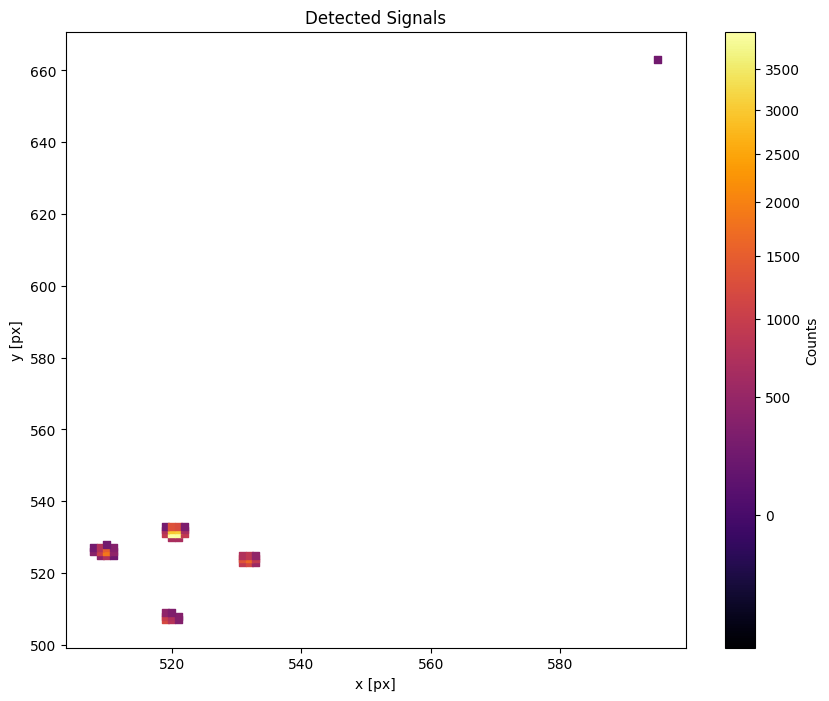

In [ ]:
# Plotting only detected signals
plt.figure(figsize=(10,8))
plt.scatter(mask['x'], mask['y'], c=mask['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.title('Detected Signals')

In [63]:
# Initialize image column for counting number of images
mask['image'] = pd.DataFrame(np.zeros(len(mask)))

In [64]:
# Image detection / No of Images 
coordinates = list(zip(mask['x'], mask['y']))
visited = set()  
current_image = 1 

def find_images(x, y, image_no):
    stack = [(x, y)]
    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))
    
        mask.loc[(mask['x'] == cx) & (mask['y'] == cy), 'image'] = image_no
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]:
            nx, ny = cx + dx, cy + dy
            if (nx, ny) in coordinates and (nx, ny) not in visited:
                stack.append((nx, ny))

for x, y in coordinates:
    if (x, y) not in visited:
        find_images(x, y, current_image)
        current_image += 1 

In [65]:
mask

x   y       counts detection  image
0   62  49   249.743276      True    1.0
1   61  50   346.030092      True    1.0
2   62  50  1082.029049      True    1.0
3   63  50  1011.788812      True    1.0
4   61  51   301.572754      True    1.0
5   62  51  1272.746826      True    1.0
6   63  51  1029.548981      True    1.0
7   64  51   268.603618      True    1.0
8   62  52   389.756938      True    1.0
9   63  52   328.281303      True    1.0
10  74  66   680.397618      True    2.0
11  75  66  1010.043130      True    2.0
12  76  66   316.183921      True    2.0
13  74  67  1478.511621      True    2.0
14  75  67  2026.587328      True    2.0
15  76  67   749.195854      True    2.0
16  52  68   429.369164      True    3.0
17  53  68   671.303002      True    3.0
18  74  68   731.452987      True    2.0
19  75  68  1023.424885      True    2.0
20  76  68   392.153747      True    2.0
21  52  69  1155.821812      True    3.0
22  53  69  1841.466057      True    3.0
23  54  69   754.046060      True    3.0
24  52  70   801.042636      True    3.0
25  53  70  1257.972589      True    3.0
26  54  70   521.088007      True    3.0
27  53  71   267.966083      True    3.0
28  62  73   272.643569      True    4.0
29  63  73   898.535902      True    4.0
30  64  73   908.945971      True    4.0
31  65  73   270.859518      True    4.0
32  62  74   736.538531      True    4.0
33  63  74  3617.086404      True    4.0
34  64  74  3743.716448      True    4.0
35  65  74   929.853796      True    4.0
36  62  75   762.813136      True    4.0
37  63  75  3341.248395      True    4.0
38  64  75  3360.758727      True    4.0
39  65  75   839.562134      True    4.0
40  63  76   904.206962      True    4.0
41  64  76   806.838884      True    4.0

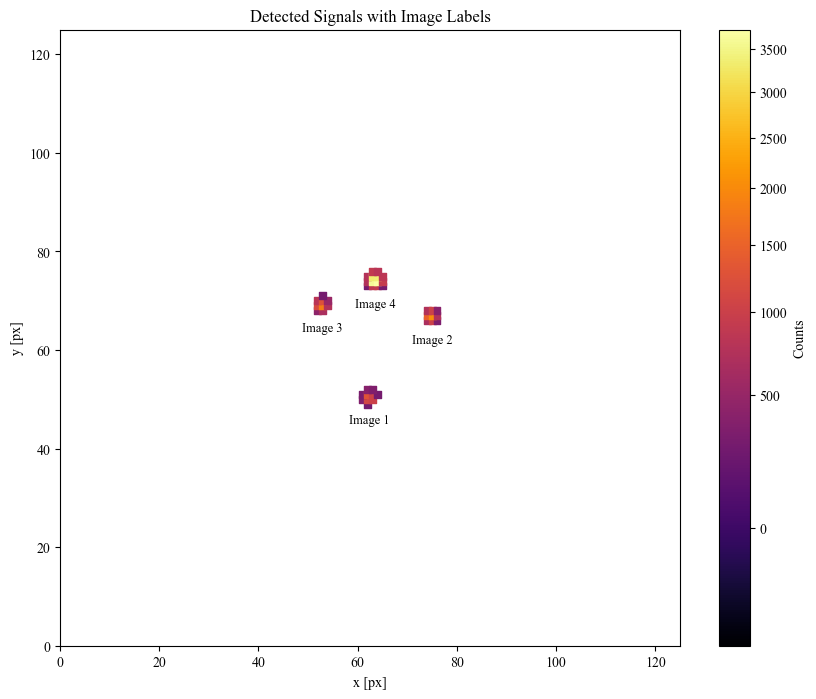

In [66]:
# Plot with images labelled
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mask['x'], mask['y'], c=mask['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.colorbar(scatter, label='Counts')

for image_id in mask['image'].unique():
    # Centroid for labelling 
    images = mask[mask['image'] == image_id]
    centroid_x = images['x'].mean()
    centroid_y = images['y'].mean() - 5
    plt.text(centroid_x, centroid_y, f'Image {int(image_id)}', fontsize=9, color='k', ha='center', va='center')

plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Detected Signals with Image Labels')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.show()


In [67]:
# Counts to flux conversion
df['flux'] = (df['counts'] * flux_density * flux_wavelength) / exposure

In [68]:
df

x    y     counts  detection          flux
0        1    1  -9.503815      False -1.191056e-17
1        2    1  45.082628      False  5.649935e-17
2        3    1 -11.024845      False -1.381678e-17
3        4    1 -49.632880      False -6.220191e-17
4        5    1   1.603657      False  2.009767e-18
...    ...  ...        ...        ...           ...
15620  121  125 -95.056878      False -1.191291e-16
15621  122  125  45.885237      False  5.750521e-17
15622  123  125  -3.245719      False -4.067665e-18
15623  124  125   8.055923      False  1.009600e-17
15624  125  125  30.900071      False  3.872521e-17

[15625 rows x 5 columns]

# Fitting the PSF

In [69]:
# Fitting the PSF 

# Backgorund estimation and subtraction (Done since PSFPhotomtery requires background subtraction)
# Procedure from https://photutils.readthedocs.io/en/stable/background.html#background

from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.0, maxiters=20)
threshold = detect_threshold(image_data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image_data, threshold, npixels=5)
footprint = circular_footprint(radius=5)
mask = segment_img.make_source_mask(footprint=footprint)
bkg_estimator = MedianBackground()
bkg = Background2D(image_data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask=mask)

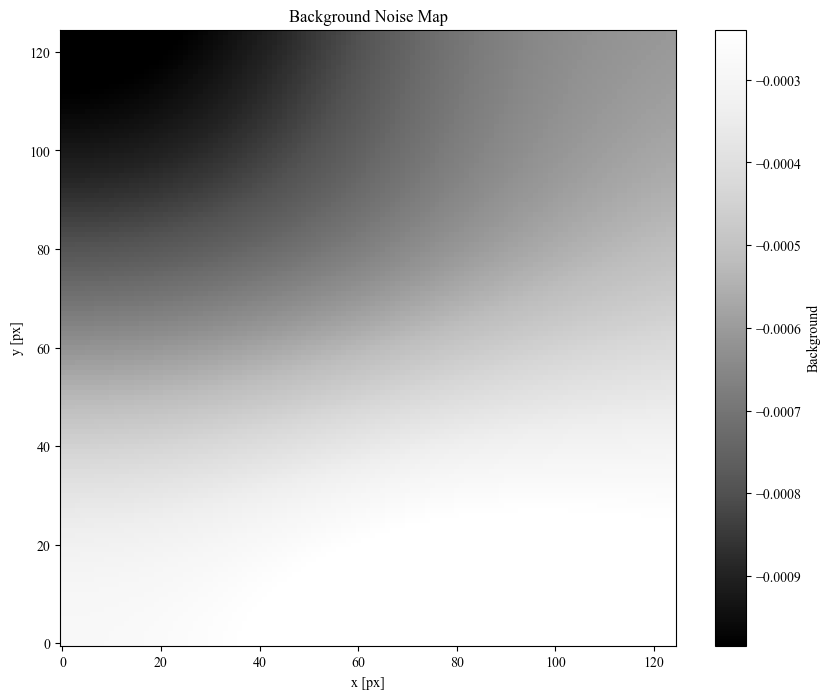

In [70]:
# Plotting the sky background
plt.figure(figsize=(10, 8))
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar(label='Background')
plt.title('Background Noise Map')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.show()

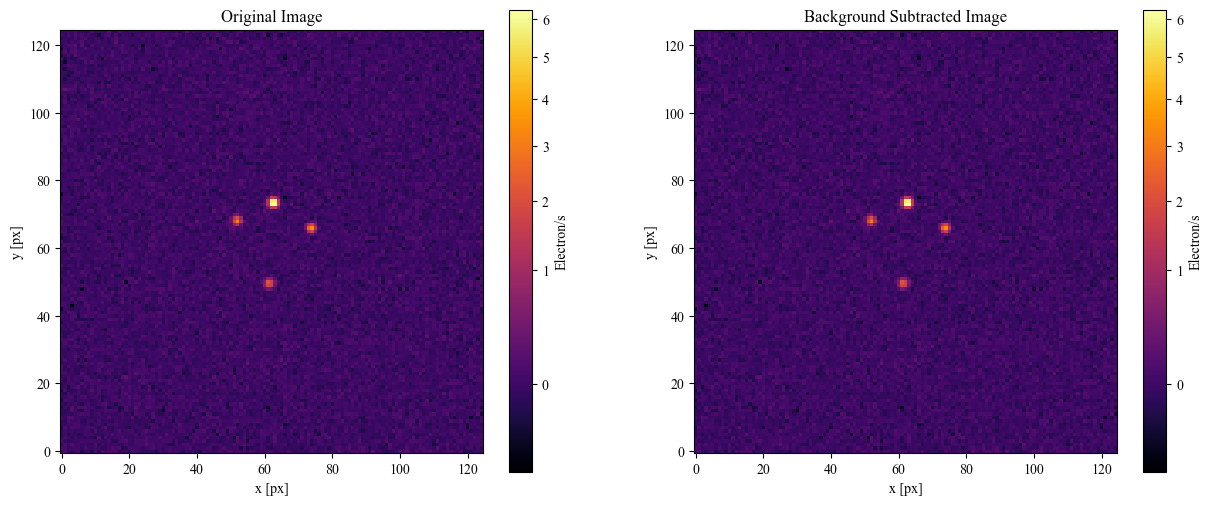

In [71]:
# Background subtracted image
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data,cmap='inferno', origin='lower', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.colorbar(label='Electron/s')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(image_data - bkg.background, norm=norm, origin='lower',cmap='inferno')
plt.colorbar(label='Electron/s')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Background Subtracted Image')
plt.show()

In [72]:
# Subtracting the background
image_data = image_data - bkg.background

Number of Images: 4
 id  x_fit   y_fit  flux_fit
--- ------- ------- --------
  1 61.4083 49.5811  12.3607
  2 73.7340 66.0164  16.5642
  3 51.8180 68.2530  15.1961
  4 62.5178 73.4528  39.0596


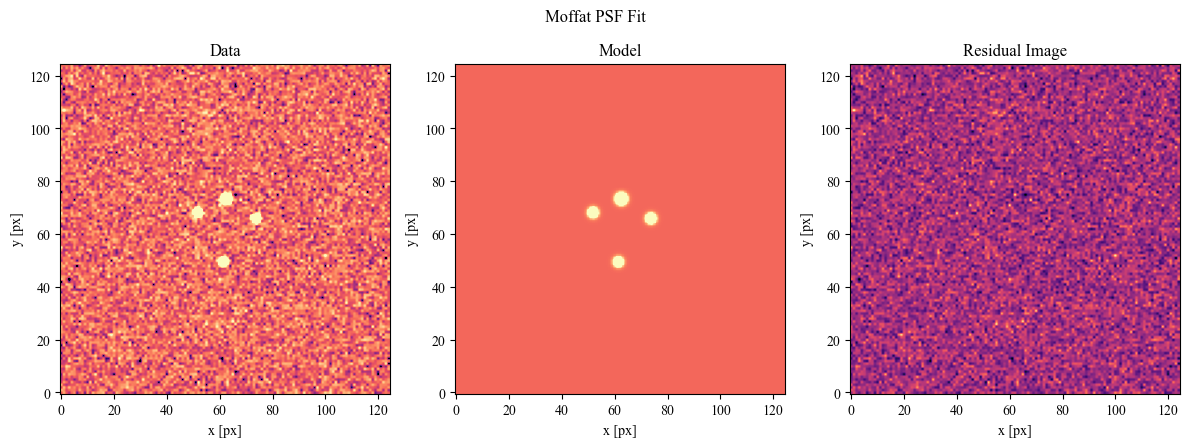

In [73]:
# Moffat PSF fitting
psf_model = MoffatPSF(flux=2, alpha=2.5, beta=5.5)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
plt.suptitle('Moffat PSF Fit', y=0.67)
plt.tight_layout()


In [74]:
# # Moffat Grid Search 
# flux = np.arange(1, 10, 1)
# alpha = np.arange(1, 5, 0.5)
# beta = np.arange(1, 5, 0.5)
# fwhm = np.arange(1, 5, 0.5)
# threshold = np.arange(1, 5, 0.5)
# param_permutations = [(f, a, b, w, t) for f in flux for a in alpha for b in beta for w in fwhm for t in threshold]
# results = pd.DataFrame(columns=['flux', 'alpha', 'beta', 'fwhm', 'threshold', 'std_resid'])

# for f, a, b, w, t in tqdm(param_permutations, desc='Grid Search', total=len(param_permutations)):
#     psf_model = MoffatPSF(flux=f, alpha=a, beta=b)
#     fit_shape = (5, 5)
#     finder = DAOStarFinder(fwhm=w, threshold=t)
#     psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
#     if psfphot(image_data) is None:
#         continue
#     resid = psfphot.make_residual_image(image_data, (9, 9))
#     std_resid = np.std(resid)
#     new_row = pd.DataFrame({'flux': [f], 'alpha': [a], 'beta': [b], 'fwhm': [w], 'threshold': [t], 'std_resid': [std_resid]})
#     results = pd.concat([results, new_row], ignore_index=True)

# best_params = results.loc[results['std_resid'].idxmin()]
# print('Best Parameters:', best_params)


Number of Images: 4
 id  x_fit   y_fit  flux_fit
--- ------- ------- --------
  1 61.4031 49.5898  11.8701
  2 73.7504 66.0158  16.1008
  3 51.8298 68.2418  14.7334
  4 62.5208 73.4521  37.4691


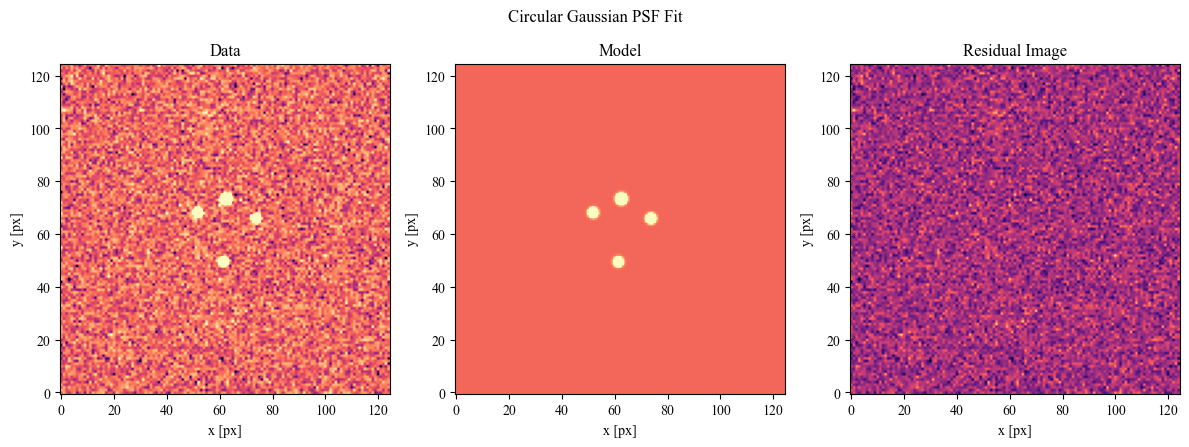

In [75]:
# Circular Gaussian PSF fitting
psf_model = CircularGaussianPSF(flux=1,fwhm=2.0)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
plt.suptitle('Circular Gaussian PSF Fit', y=0.67)
plt.tight_layout()

Number of Images: 4
 id  x_fit   y_fit  flux_fit
--- ------- ------- --------
  1 61.4031 49.5898  11.8701
  2 73.7504 66.0158  16.1008
  3 51.8298 68.2418  14.7334
  4 62.5208 73.4521  37.4691


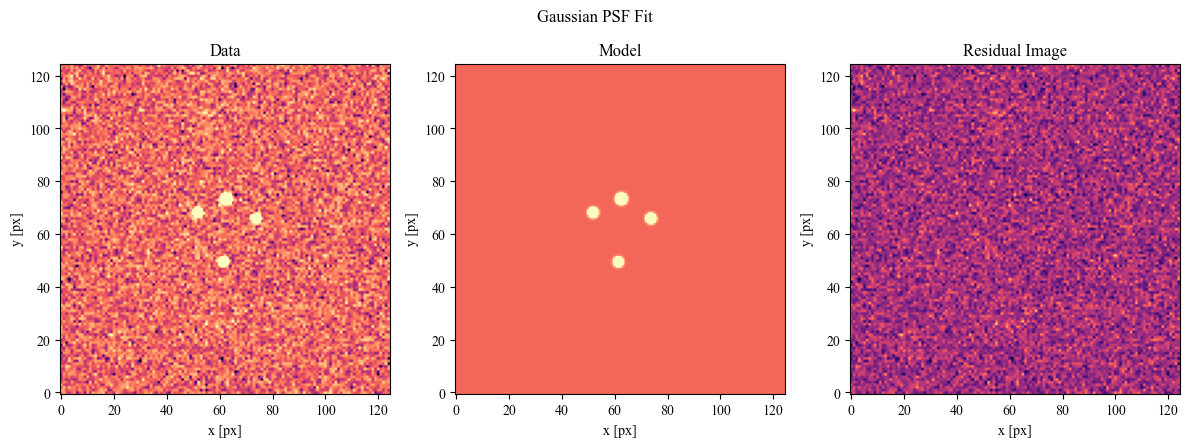

In [76]:
# Gaussian PSF fitting
psf_model = GaussianPSF(flux=1, x_fwhm=2.0, y_fwhm=2.0)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.5)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
plt.suptitle('Gaussian PSF Fit', y=0.67)
plt.tight_layout()

In [77]:
## Gaussian Grid Search
# flux = np.arange(1, 10, 1)
# x_fwhm = np.arange(1, 5, 0.5)
# y_fwhm = np.arange(1, 5, 0.5)
# threshold = np.arange(1, 5, 0.5)
# fwhm = np.arange(1, 5, 0.5)
# param_permutations = [(f, x, y, t, w) for f in flux for x in x_fwhm for y in y_fwhm for t in threshold for w in fwhm]

# results = pd.DataFrame(columns=['flux', 'x_fwhm', 'y_fwhm', 'threshold', 'fwhm', 'std_resid'])

# for f, x, y, t, w in tqdm(param_permutations, desc='Grid Search', total=len(param_permutations)):
#     psf_model = GaussianPSF(flux=f, x_fwhm=x, y_fwhm=y)
#     fit_shape = (5, 5)
#     finder = DAOStarFinder(fwhm=w, threshold=t)
#     psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
#     if psfphot(image_data) is None:
#         continue
#     resid = psfphot.make_residual_image(image_data, (9, 9))
#     std_resid = np.std(resid)
#     new_row = pd.DataFrame({'flux': [f], 'x_fwhm': [x], 'y_fwhm': [y], 'threshold': [t], 'fwhm': [w], 'std_resid': [std_resid]})
#     results = pd.concat([results, new_row], ignore_index=True)

# best_params = results.loc[results['std_resid'].idxmin()]
# print('Best Parameters:', best_params)

# Position and Flux Unit Conversion

In [78]:
# Take columns from correct PSF Fit
phot

<QTable length=4>
  id  group_id group_size ...         qfit                  cfit         flags
int64  int64     int64    ...       float64               float64        int64
----- -------- ---------- ... -------------------- --------------------- -----
    1        1          1 ...  0.09924930675443751  0.003306494868650685     0
    2        2          1 ...  0.08872624832543456 -0.001455791257418357     0
    3        3          1 ...  0.09841709559293027 0.0006907442371999065     0
    4        4          1 ... 0.046133516354551034 0.0032293890931755494     0

In [80]:
# Convert from CPS to Flux
images = pd.DataFrame(columns=['x', 'x_err', 'y', 'y_err', 'flux', 'flux_err', 'image'])
images['x'] = phot['x_fit']
images['x_err'] = phot['x_err']
images['y'] = phot['y_fit']
images['y_err'] = phot['y_err']
images['flux'] = phot['flux_fit']
images['flux_err'] = phot['flux_err']
images['image'] = phot['id']

In [81]:
images.to_csv('pred.csv', index=False)

In [43]:
# Unit Conversion
images['flux'] = (images['flux'] * exposure) * flux_density * flux_wavelength / exposure
images['flux_err'] = (images['flux_err'] * exposure) * flux_density * flux_wavelength / exposure
images['x_pix'] = images['x']
images['y_pix'] = images['y']
images['x_pix_err'] = images['x_err']
images['y_pix_err'] = images['y_err']
images['x'] = images['x'] * pix_size
images['y'] = images['y'] * pix_size
images['x_err'] = images['x_err'] * pix_size
images['y_err'] = images['y_err'] * pix_size

In [44]:
images

x     x_err         y     y_err          flux      flux_err  image  \
0  2.456124  0.000735  1.983594  0.000735  8.925655e-15  1.378091e-16      1   
1  2.950014  0.000646  2.640633  0.000653  1.210690e-14  1.626710e-16      2   
2  2.073191  0.000763  2.729672  0.000759  1.107870e-14  1.749015e-16      3   
3  2.500831  0.000360  2.938084  0.000360  2.817467e-14  2.131037e-16      4   

       x_pix      y_pix  x_pix_err  y_pix_err  
0  61.403103  49.589840   0.018381   0.018376  
1  73.750355  66.015834   0.016142   0.016327  
2  51.829783  68.241797   0.019070   0.018977  
3  62.520786  73.452096   0.008990   0.008993

In [45]:
max_flux = images['flux'].max()
max_flux_index = images['flux'].idxmax()
max_flux_err = images['flux_err'][max_flux_index]
print('Max Flux:', max_flux)
print('Max Flux Error:', max_flux_err)
images['flux_ratio'] = images['flux'] / max_flux

Max Flux: 2.8174669214682708e-14
Max Flux Error: 2.131036523044542e-16


In [46]:
def fluxratio_err(flux, flux_err, max_flux, max_flux_err):
    term1 = ((1/max_flux) * flux_err)**2
    term2 = ((-(flux/max_flux**2))*max_flux_err)**2
    sum_terms = term1 + term2
    final = np.sqrt(sum_terms)
    return final

In [47]:
images['flux_ratio_err'] = fluxratio_err(images['flux'], images['flux_err'], max_flux, max_flux_err)

In [48]:
images

x     x_err         y     y_err          flux      flux_err  image  \
0  2.456124  0.000735  1.983594  0.000735  8.925655e-15  1.378091e-16      1   
1  2.950014  0.000646  2.640633  0.000653  1.210690e-14  1.626710e-16      2   
2  2.073191  0.000763  2.729672  0.000759  1.107870e-14  1.749015e-16      3   
3  2.500831  0.000360  2.938084  0.000360  2.817467e-14  2.131037e-16      4   

       x_pix      y_pix  x_pix_err  y_pix_err  flux_ratio  flux_ratio_err  
0  61.403103  49.589840   0.018381   0.018376    0.316797        0.005447  
1  73.750355  66.015834   0.016142   0.016327    0.429709        0.006626  
2  51.829783  68.241797   0.019070   0.018977    0.393215        0.006883  
3  62.520786  73.452096   0.008990   0.008993    1.000000        0.010697

(0.0, 5.0)

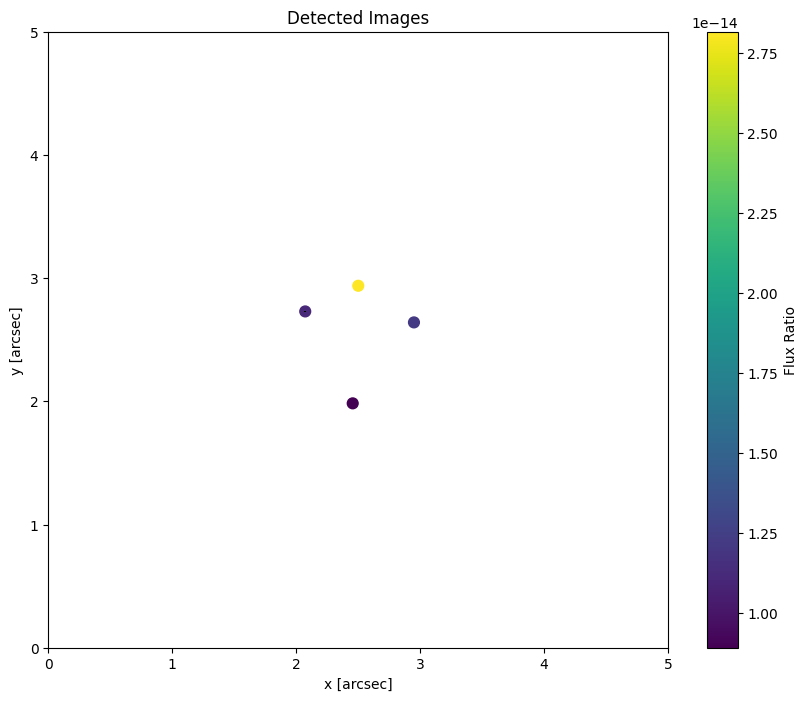

In [62]:
plt.figure(figsize=(10, 8))
plt.scatter(images['x'], images['y'], c=images['flux'], s=60)
plt.errorbar(images['x'], images['y'], xerr=images['x_err'], yerr=images['y_err'], fmt='o', markersize=0, color='k')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.colorbar(label='Flux Ratio')
plt.title('Detected Images')
plt.xlim(0, 5)
plt.ylim(0, 5)


# IMFIT Fitting

In [1]:
from astropy.io import fits
import pyimfit
pyimfit.imageFunctionDict['Gaussian']

['PA', 'ell', 'I_0', 'sigma']

In [ ]:
# Config File Builder 
file = open('config.dat', 'w')
file.write('GAIN' + ' ' + gain)
file.write('READNOISE' + ' '+ rdnoise)
file.write('EXPTIME' + ' ' + exposure)
file.write('X0' )
file.write('Y0')
file.write('FUNCTION Gaussian')
file.write('PA' + '    ' + '0.0' + '    ' + '0,180')
file.write('ell' + '    ' + '0.0' + '    ' + '0,1')
file.write('I_0' + '    ' + '30000' + '    ' + '0,50000')
file.write('sigma' + '    ' + '5' + '    ' + '0,100')

In [10]:

imageFile = "Rommulus_lens copy.fits"
configFile = "config.dat"

# read in image data
image_data = fits.getdata(imageFile)

# construct model (ModelDescription object) from config file
model_desc = pyimfit.ModelDescription.load(configFile)

# create an Imfit object, using the previously loaded model configuration
imfit_fitter = pyimfit.Imfit(model_desc)

# load the image data and image characteristics and do a standard fit
# (using default chi^2 statistics and Levenberg-Marquardt solver)
fit_result = imfit_fitter.fit(image_data[67:87, 50:70], gain=1.6, read_noise=3.08, solver='DE', verbose=1)
print(fit_result)

# check the fit and print the resulting best-fit parameter values
if imfit_fitter.fitConverged is True:
    print("Fit converged: chi^2 = {0}, reduced chi^2 = {1}".format(imfit_fitter.fitStatistic,
        imfit_fitter.reducedFitStatistic))
    print("Best-fit parameter values:")
    print(imfit_fitter.getRawParameters())

Calling Differential Evolution solver ..
            aic: 18.747777500634154
            bic: 42.482824325266776
   fitConverged: True
        fitStat: 6.534037042618888
 fitStatReduced: 0.016583850361976873
     nFuncEvals: 10080
          nIter: -1
      paramErrs: None
         params: array([8.99999999e+01, 5.00000001e+01, 1.12787360e+02, 9.94083805e-01,
       3.00000000e+04, 1.63505310e+01])
     solverName: 'DE'
Fit converged: chi^2 = 6.534037042618888, reduced chi^2 = 0.016583850361976873
Best-fit parameter values:
[8.99999999e+01 5.00000001e+01 1.12787360e+02 9.94083805e-01
 3.00000000e+04 1.63505310e+01]
   DESolver::Setup -- using uniform sampling.

Generation    0: bestEnergy = 6.5433343056
Generation   10: bestEnergy = 6.5431796673
Generation   20: bestEnergy = 6.5431074662   (relative change = 1.103468e-05)
Generation   30: bestEnergy = 6.5429669045   (relative change = 2.148287e-05)
Generation   40: bestEnergy = 6.5415907359   (relative change = 2.103722e-04)
Generation 

# Lens Modelling

Assume a standard λCDM Cosmology

In [1]:
# # Old Code
# # Galfic Plotting Code
# from astropy.io import fits
# import warnings
# warnings.filterwarnings('ignore')

# # Glafic Tabular 

# # Read_script.py
# # Open the Python file as a text file

# def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
#     with open(filename_0, 'r') as file:
#         # Read the contents of the file
#         content = file.read()
#         file.close()
    
#     with open(filename_6, 'r') as file:
#         content_opt = file.read()
#         file.close()

#     # Define a function to find a line in the file
#     def find_line(word, content):
#         content = content.split('\n')
#         line_number = 0
#         for line in content:
#             line_number += 1
#             if word in line:
#                 return line_number
#         return "Line Not Found"
    
#     def find_last_line(word, content):
#         content = content.split('\n')
#         line_number = 0
#         last_occurrence = -1
#         for line in content:
#             line_number += 1
#             if word in line:
#                 last_occurrence = line_number
#         return last_occurrence

#     # Set lens line number
#     line_set_1 = find_line('glafic.set_lens(1,', content)
#     line_opt_1 = find_line('glafic.setopt_lens(1,', content)

#     if shear == True:
#         line_set_2 = find_line('glafic.set_lens(2,', content)
#         line_opt_2 = find_line('glafic.setopt_lens(2,', content)

#     # Split the content by new line
#     content_list = content.split('\n')

#     # Get the set_lens line
#     set_lens_1 = content_list[line_set_1-1]

#     # Get the setopt_lens line
#     setopt_lens_1 = content_list[line_opt_1-1]

#     # Define the list of possible models
#     models = ['SIE', 'POW', 'NFW']

#     parts_set_lens = set_lens_1.split(',')
#     parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

#     parts_setopt_lens = setopt_lens_1.split(',')
#     parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


#     if shear == True:
#     # Get the shear set_lens line
#         set_lens_2 = content_list[line_set_2-1]

#         # Get the shear setopt_lens line
#         setopt_lens_2 = content_list[line_opt_2-1]

#         parts_set_lens_2 = set_lens_2.split(',')
#         parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

#         parts_setopt_lens_2 = setopt_lens_2.split(',')
#         parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

#         if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
#             raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

#         if 'pert' in set_lens_2:
#             name = 'Shear'
#             z_s = parts_set_lens_2[3]
#             x = parts_set_lens_2[4]
#             y = parts_set_lens_2[5]
#             gamma = parts_set_lens_2[6]
#             pa = parts_set_lens_2[7]
#             NaN = parts_set_lens_2[8]
#             pwi = parts_set_lens_2[9].replace(')', '') 

#             z_s_flag = parts_setopt_lens_2[2]
#             x_flag = parts_setopt_lens_2[3]
#             y_flag = parts_setopt_lens_2[4]
#             gamma_flag = parts_setopt_lens_2[5]
#             pa_flag = parts_setopt_lens_2[6]
#             NaN_flag = parts_setopt_lens_2[7]
#             pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

#             line = find_last_line('lens   pert', content_opt)
#             line_content = content_opt.split('\n')[line - 1]
#             line_list = line_content.split()

#             row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
#             row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
#             row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#             row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

#             table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
#             if show_shear:
#                 print(table_shear)

#             if save_table_flag:
#                 table_shear.to_csv('shear_table.csv')
#         return table_shear

#     if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
#         raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
#     for i in models:
#         i = i.lower()
#         if i in set_lens_1:
#             if i == models[1].lower(): # POW model
#                 name = models[1]
#                 z_s = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 r_ein = parts_set_lens[8]
#                 pwi = parts_set_lens[9].replace(')', '') 

#                 z_s_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 r_ein_flag = parts_setopt_lens[7]
#                 pwi_flag = parts_setopt_lens[8].replace(')', '') 

#                 line = find_last_line('lens   pow', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
#                 row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

#             elif i == models[0].lower(): # SIE model
#                 name = models[0]
#                 sigma = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 r_core = parts_set_lens[8]
#                 pwi = parts_set_lens[9].replace(')', '') 

#                 sigma_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 r_core_flag = parts_setopt_lens[7]
#                 pwi_flag = parts_setopt_lens[8].replace(')', '') 

#                 line = find_last_line('lens   sie', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
#                 row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

#             elif i == models[2].lower(): # NFW model    
#                 name = models[2]
#                 m = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 c = parts_set_lens[8]
#                 Nan = parts_set_lens[9].replace(')', '') 

#                 m_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 c_flag = parts_setopt_lens[7]
#                 Nan_flag = parts_setopt_lens[8].replace(')', '')

#                 line = find_last_line('lens   anfw', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
#                 row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
#             if show_params:
#                 print(table)

#             if save_table_flag:
#                 table.to_csv('table.csv')
            
#             return table, chi_list

#     print("Model not found")
#     return None  # Explicitly return None if no model is found



# # Position and Magnification Plots

# def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
#                table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
#     if table_flag:
#         if glafic_file_1 is None:
#             print("Please provide the filename for the glafic script")
#             raise ValueError("Glafic File not provided")
#         elif glafic_file_2 is None:
#             print("Please provide the Opt Result filename for the glafic script")
#             raise ValueError("Glafic File not provided")

#     if table_flag:    
#         table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
#         if table is None:
#             raise ValueError("Failed to create the table from the glafic file.")

#     if shear:
#         table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
#         if table_shear is None:
#             raise ValueError("Failed to create the table from the glafic file.")
        
#     # Storage for parsed data
#     data = []
    
#     val = pd.read_csv(filename_4)
#     val.__dataframe__
#     val_column = val.columns[0]

#     # Split the values in the data_column and expand into separate columns
#     val = val[val_column].str.split(expand=True)

#     # Convert the DataFrame to numeric type
#     val = val.apply(pd.to_numeric)

#     # Line by line read (Remove # from obs file)
#     with open(filename_1, 'r') as file:
#         for line in file:
#             # Skip lines starting with "#"
#             if line.startswith("#"):
#                 continue
            
#             # Split the line by whitespace
#             line_data = line.split()
            
#             # Remove # 
#             line_data = [float(val) for val in line_data if val != '#']  
            
#             data.append(line_data)
    
#     # Convert to DataFrame
#     data_df = pd.DataFrame(data)

#     # Exclude the first row
#     data_df = data_df.iloc[1:]

#     data_df.insert(8, "Label", ['Red Image','Green Image','Blue Image','Yellow Image'], True)

#     data_df = data_df.drop(columns =[5, 6, 7])

#     # Read and process the predicted data
#     data_pred = pd.read_csv(filename_2, header=None, delim_whitespace=True, comment='#')
#     df_pred = data_pred.iloc[1:]

#     # Function for swapping data 
#     def swap_rows(df, row1, row2):
#         df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
#         return df
    
#     # For loop to iterate over row range for row swapping
#     for i in range(4):
#         diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
#         m = diff.idxmin()
#         n = min(diff)
#         if n < 0.01:
#             df_pred = swap_rows(df_pred, i, (m-1))
#         else:
#             continue

#     df_pred = df_pred.drop(columns =[3])

#     # Eliminating the 5th image
#     if len(df_pred[2])>num_images:
#         i = len(df_pred[2]) - num_images
#         for j in range(i):
#             min_vales = np.min(abs(df_pred[2]))
#             df_2 = abs(df_pred)
#             b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
#             df_3 = df_pred.drop((b+1), axis='index')
#             df_pred = df_3
#             df_pred.reset_index(drop=True, inplace=True)
#         df_pred.index = df_pred.index + 1

#     # Calculations for Position Error values
#     d_x = abs(abs(data_df[0])-abs(df_pred[0]))
#     d_y = abs(abs(data_df[1])-abs(df_pred[1]))
#     sum_sq = (d_x**2) + (d_y**2)
#     sq = np.sqrt(sum_sq)
#     rms = np.average(sq)
#     rms_unit = rms*1000
#     rms_round = round(rms_unit, 3)/1000
#     rms_str = str(rms_round)

#     # Plotting Position Error Graph
#     # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#     # sns.set_theme(style="ticks", rc=custom_params)

#     colours1 = ['lightsalmon', 'green', 'gold', 'blue']
#     colours = [(0.1,0.4,1.0,0.7), (0.0,0.7,0.4,0.7), (0.7,0.3,0.4,0.7), (0.8,0.7,0.1,0.7)]
#     plt.figure(figsize=(15, 5))
#     plt.subplot(1, 3, 1)
#     plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
#     plt.axhline(xmin=0.045, xmax=0.13, y=data_df[3][1], linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
#     plt.axhline(xmin=0.32, xmax=0.40, y=data_df[3][2], linestyle ='--', color ='r', linewidth = 2)
#     plt.axhline(xmin=0.6, xmax=0.68, y=data_df[3][3], linestyle ='--', color ='r', linewidth = 2)
#     plt.axhline(xmin=0.87, xmax=0.95, y=data_df[3][4], linestyle ='--', color ='r', linewidth = 2)
#     plt.title('ΔRMS = ' + rms_str, fontsize=10)
#     plt.legend(loc='upper right', fontsize='small')
#     plt.xticks(fontsize=8)
#     plt.ylim()
#     plt.xlabel('Position error')
#     plt.ylabel('Positional offset')

#     # Calculations for Magnification value
#     # Previous Code: f = df_pred[2][1]
#     f = max(abs(df_pred[2]))
#     flux = df_pred[2]/f
#     df_pred[3] = flux 

#     df_pred[3] = abs(df_pred[3])

#     # Create data 
#     x = np.arange(4)
#     width = 0.3

#     # Maximum position error 
#     max_pos_err = max(data_df[3])

#     # FITS image processing for predicted flux at observed positions 
#     image = fits.open(filename_5)
#     values = image[0].data
#     image.close()
#     dat = values[6]
#     g = data_df[0]/0.04
#     h = data_df[1]/0.04
#     g_max = (data_df[0]/0.04 + (max_pos_err/0.04))
#     h_max = (data_df[1]/0.04 + (max_pos_err/0.04))
#     g_min = (data_df[0]/0.04 - (max_pos_err/0.04))
#     h_min = (data_df[1]/0.04 - (max_pos_err/0.04))

#     x_pos = g
#     y_pos = h
#     x_pos_max = g_max
#     y_pos_max = h_max
#     x_pos_min = g_min
#     y_pos_min = h_min

#     x_pos = x_pos.astype(int)
#     y_pos = y_pos.astype(int)
#     x_pos_max = x_pos_max.astype(int)
#     y_pos_max = y_pos_max.astype(int)
#     x_pos_min = x_pos_min.astype(int)
#     y_pos_min = y_pos_min.astype(int)

#     flux_pos = []
#     flux_pos_max = []
#     flux_pos_min = []

#     for i in range(1,5):
#         flux_cal = dat[y_pos[i]][x_pos[i]]
#         flux_pos.append(flux_cal)

#     for i in range(1,5):
#         flux_cal_max = dat[y_pos_max[i]][x_pos_max[i]]
#         flux_pos_max.append(flux_cal_max)
    
#     for i in range(1,5):
#         flux_cal_min = dat[y_pos_min[i]][x_pos_min[i]]
#         flux_pos_min.append(flux_cal_min)
    
#     flux_pos = [abs(x) for x in flux_pos]
#     flux_pos_max = [abs(x) for x in flux_pos_max]
#     flux_pos_min = [abs(x) for x in flux_pos_min]

#     l = max(flux_pos)
#     true_flux = flux_pos/l
#     true_flux = abs(true_flux)

#     l_max = max(flux_pos_max)
#     true_flux_max = flux_pos_max/l_max
#     true_flux_max = abs(true_flux_max)

#     l_min = max(flux_pos_min)
#     true_flux_min = flux_pos_min/l_min
#     true_flux_min = abs(true_flux_min)

#     arrow_legnths = true_flux_max - true_flux_min

#     height = max(true_flux) + 0.4
#     # Plotting Flux Error Graph
#     plt.subplot(1, 3, 2)
#     plt.bar(x+0.15, val[0], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
#     plt.bar(x-0.15, df_pred[3], width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
#     plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
#     # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
#     plt.errorbar(x+0.15, val[0], yerr=val[1], fmt='o', color='black', capsize=6, label='1 σ Error')
#     plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
#     plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.xlabel("Flux ratio error") 
#     plt.ylabel("Flux Ratio") 
#     plt.ylim(0, height)
#     plt.legend(loc = 'upper right', fontsize=7)
#     plt.title('Relative brightness error', fontsize=10)
#     plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
#     if table_flag:
#         table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
#         table_plot.auto_set_font_size(False)
#         table_plot.set_fontsize(10)
#         if shear == True:
#             table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
#             table_shear_plot.auto_set_font_size(False)
#             table_shear_plot.set_fontsize(10)
    

#     return data_df, df_pred



# # Critical Curves Plot

# def critcurve_plot(filename_1, filename_2, filename_3, plot_name, num_images):
#     data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
#     data_crit.__dataframe__
#     df = data_crit.iloc[1:]

#     # Initialize empty list 
#     data = []
    
#     # Line by line checking
#     with open(filename_1, 'r') as file:
#         for line in file:
#             # Skip lines starting with #
#             if line.startswith("#"):
#                 continue
            
#             # Split by space
#             line_data = line.split()
            
#             # Remove #
#             line_data = [float(val) for val in line_data if val != '#']  # Exclude '#' characters
            
#             data.append(line_data)
    
#     # Convert the list of lists to a DataFrame
#     data_df = pd.DataFrame(data)

#     # Exclude the first row
#     data_df = data_df.iloc[1:]

#     # Read and process the predicted data
#     de = pd.read_csv(filename_2, header=None, delim_whitespace=True, comment='#')
#     de = de.iloc[1:]

#     # Function for swapping data 
#     def swap_rows(df, row1, row2):
#         df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
#         return df
    
#     # For loop to iterate over row range for row swapping
#     for i in range(4):
#         diff = abs(abs(data_df.iloc[i,0]) - abs(de[0]))
#         m = diff.idxmin()
#         n = min(diff)
#         if n < 0.01:
#             de = swap_rows(de, i, (m-1))
#         else:
#             continue

        
#     de = de.drop(columns =[3])

#     # Eliminating the 5th image
#     if len(de[2])>num_images:
#         i = len(de[2]) - num_images
#         for j in range(i):
#             min_vales = np.min(abs(de[2]))
#             df_4 = abs(de)
#             b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
#             df_5 = de.drop((b+1), axis='index')
#             de = df_5
#             de.reset_index(drop=True, inplace=True)
#         de.index = de.index + 1

#     labels = ['A', 'B', 'C', 'D']

#     # Plotting Critial Curves
#     plt.subplot(1, 3, 3)
#     plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
#     plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
#     plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
#     plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

#     colors = ['red',  'green', 'blue', 'gold']
#     # Plotting obs image positions and labels 
#     plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
#     plt.scatter(data_df[0]/0.04, data_df[1]/0.04, s=15, color = colors, marker = 'o')
#     # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
#     #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

#     plt.title('')
#     plt.tick_params(labelsize=8)
#     plt.xlabel('x [Pixel]')
#     plt.ylabel('y [Pixel]')
#     plt.xlim(30, 95)
#     plt.ylim(30, 95)
#     plt.show()
    
#     return data_df, df

In [192]:
# Galfic Plotting Code
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

# Glafic Tabular 

# Read_script.py
# Open the Python file as a text file
def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
    with open(filename_0, 'r') as file:
        # Read the contents of the file
        content = file.read()
        file.close()
    
    with open(filename_6, 'r') as file:
        content_opt = file.read()
        file.close()

    # Define a function to find a line in the file
    def find_line(word, content):
        content = content.split('\n')
        line_number = 0
        for line in content:
            line_number += 1
            if word in line:
                return line_number
        return "Line Not Found"
    
    def find_last_line(word, content):
        content = content.split('\n')
        line_number = 0
        last_occurrence = -1
        for line in content:
            line_number += 1
            if word in line:
                last_occurrence = line_number
        return last_occurrence

    # Set lens line number
    line_set_1 = find_line('glafic.set_lens(1,', content)
    line_opt_1 = find_line('glafic.setopt_lens(1,', content)

    if shear == True:
        line_set_2 = find_line('glafic.set_lens(2,', content)
        line_opt_2 = find_line('glafic.setopt_lens(2,', content)

    # Split the content by new line
    content_list = content.split('\n')

    # Get the set_lens line
    set_lens_1 = content_list[line_set_1-1]

    # Get the setopt_lens line
    setopt_lens_1 = content_list[line_opt_1-1]

    # Define the list of possible models
    models = ['SIE', 'POW', 'NFW']

    parts_set_lens = set_lens_1.split(',')
    parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

    parts_setopt_lens = setopt_lens_1.split(',')
    parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


    if shear == True:
    # Get the shear set_lens line
        set_lens_2 = content_list[line_set_2-1]

        # Get the shear setopt_lens line
        setopt_lens_2 = content_list[line_opt_2-1]

        parts_set_lens_2 = set_lens_2.split(',')
        parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

        parts_setopt_lens_2 = setopt_lens_2.split(',')
        parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

        if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
            raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

        if 'pert' in set_lens_2:
            name = 'Shear'
            z_s = parts_set_lens_2[3]
            x = parts_set_lens_2[4]
            y = parts_set_lens_2[5]
            gamma = parts_set_lens_2[6]
            pa = parts_set_lens_2[7]
            NaN = parts_set_lens_2[8]
            pwi = parts_set_lens_2[9].replace(')', '') 

            z_s_flag = parts_setopt_lens_2[2]
            x_flag = parts_setopt_lens_2[3]
            y_flag = parts_setopt_lens_2[4]
            gamma_flag = parts_setopt_lens_2[5]
            pa_flag = parts_setopt_lens_2[6]
            NaN_flag = parts_setopt_lens_2[7]
            pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

            line = find_last_line('lens   pert', content_opt)
            line_content = content_opt.split('\n')[line - 1]
            line_list = line_content.split()

            row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
            row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
            row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
            row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

            table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            if show_shear:
                print(table_shear)

            if save_table_flag:
                table_shear.to_csv('shear_table.csv')
        return table_shear

    if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
        raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
    for i in models:
        i = i.lower()
        if i in set_lens_1:
            if i == models[1].lower(): # POW model
                name = models[1]
                z_s = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_ein = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                z_s_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_ein_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   pow', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
                row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[0].lower(): # SIE model
                name = models[0]
                sigma = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_core = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                sigma_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_core_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   sie', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
                row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[2].lower(): # NFW model    
                name = models[2]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                c = parts_set_lens[8]
                Nan = parts_set_lens[9].replace(')', '') 

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                c_flag = parts_setopt_lens[7]
                Nan_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   anfw', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
                row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            if show_params:
                print(table)

            if save_table_flag:
                table.to_csv('table.csv')
            
            return table, chi_list

    print("Model not found")
    return None  # Explicitly return None if no model is found



# Position and Magnification Plots

def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
               table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
    
    if table_flag:
        if glafic_file_1 is None:
            print("Please provide the filename for the glafic script")
            raise ValueError("Glafic File not provided")
        elif glafic_file_2 is None:
            print("Please provide the Opt Result filename for the glafic script")
            raise ValueError("Glafic File not provided")

    if table_flag:    
        table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
        if table is None:
            raise ValueError("Failed to create the table from the glafic file.")

    if shear:
        table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
        if table_shear is None:
            raise ValueError("Failed to create the table from the glafic file.")
        
    # Storage for parsed data
    data = []
    
    # val = pd.read_csv(filename_4)
    # val.__dataframe__
    # val_column = val.columns[0]

    # # Split the values in the data_column and expand into separate columns
    # val = val[val_column].str.split(expand=True)

    # # Convert the DataFrame to numeric type
    # val = val.apply(pd.to_numeric)

    # print(val)

    with open(filename_2, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    val = pd.DataFrame(data)
    val = val.iloc[1:]
    brightest_flux = max(val[2])
    brightest_index = val[2].idxmax()

    # Add a column called 'colour' to val
    val['colour'] = ''

    # Assign 'red' to the brightest image
    val.at[brightest_index, 'colour'] = 'red'

    # Get the coordinates of the brightest image
    brightest_x = val.at[brightest_index, 0]
    brightest_y = val.at[brightest_index, 1]

    # Calculate the angles of the other images relative to the brightest image
    angles = np.arctan2(val[1] - brightest_y, val[0] - brightest_x)

    # Sort the indices of the images by angle in clockwise order
    sorted_indices = angles.sort_values(ascending=False).index

    # Assign colours to the remaining images
    colours = ['green', 'yellow', 'blue']
    colour_index = 0
    for idx in sorted_indices:
        if val.at[idx, 'colour'] == '':
            val.at[idx, 'colour'] = colours[colour_index]
            colour_index += 1
    
    val['flux_ratio'] = abs(val[2] / brightest_flux)

    err_1 = Complex(val[2][1], val[4][1])
    err_2 = Complex(val[2][2], val[4][2])
    err_3 = Complex(val[2][3], val[4][3])
    err_4 = Complex(val[2][4], val[4][4])

    ratio_1 = str(Complex.truediv(err_1, err_2))
    ratio_2 = str(Complex.truediv(err_2, err_2))
    ratio_3 = str(Complex.truediv(err_3, err_2))
    ratio_4 = str(Complex.truediv(err_4, err_2))

    ratio_1_error = float(ratio_1.split(' ± ')[1])
    ratio_2_error = float(ratio_2.split(' ± ')[1])
    ratio_3_error = float(ratio_3.split(' ± ')[1])
    ratio_4_error = float(ratio_4.split(' ± ')[1])

    val['flux_ratio_error'] = [ratio_1_error, ratio_2_error, ratio_3_error, ratio_4_error]

    data = []

    # Line by line read (Remove # from obs file)
    with open(filename_1, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    # Convert to DataFrame
    data_df = pd.DataFrame(data)

    # Exclude the first row
    data_df = data_df.iloc[1:]
    
    data_df.insert(8, "Label", val['colour'].map({'red': 'Red Image', 'green': 'Green Image', 'yellow': 'Yellow Image', 'blue': 'Blue Image'}), True)

    # Reorder the images according to the order red, green, yellow, blue
    order = ['Red Image', 'Green Image', 'Yellow Image', 'Blue Image']
    data_df['Label'] = pd.Categorical(data_df['Label'], categories=order, ordered=True)
    data_df = data_df.sort_values('Label').reset_index(drop=True)

    data_df = data_df.drop(columns =[3, 5, 6, 7])

    # Read and process the predicted data
    data_pred = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    df_pred = data_pred.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.01:
            df_pred = swap_rows(df_pred, i, (m-1))
        else:
            continue

    df_pred = df_pred.drop(columns =[3])

    # Eliminating the 5th image
    if len(df_pred[2])>num_images:
        i = len(df_pred[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(df_pred[2]))
            df_2 = abs(df_pred)
            b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
            df_3 = df_pred.drop((b+1), axis='index')
            df_pred = df_3
            df_pred.reset_index(drop=True, inplace=True)
        df_pred.index = df_pred.index + 1

    df_pred = df_pred.reset_index(drop=True)

    # Calculations for Position Error values
    d_x = (abs(data_df[0]) - abs(df_pred[0])).abs()
    d_y = (abs(data_df[1]) - abs(df_pred[1])).abs()
    sum_sq = (d_x**2) + (d_y**2)
    sq = np.sqrt(sum_sq)
    rms = np.average(sq)
    rms_unit = rms*1000
    rms_round = round(rms_unit, 3)/1000
    rms_str = str(rms_round)

    # Plotting Position Error Graph
    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    colours1 = ['lightsalmon', 'green', 'gold', 'blue']
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
    plt.axhline(xmin=0.045, xmax=0.13, y=1.28/1000, linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
    plt.axhline(xmin=0.32, xmax=0.40, y=0.85/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.6, xmax=0.68, y=0.83/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.87, xmax=0.95, y=0.39/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.title('ΔRMS = ' + rms_str, fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.xticks(fontsize=8)
    plt.ylim(0, max(sq)+0.005)
    plt.xlabel('Position error')
    plt.ylabel('Positional offset')

    # Calculations for Magnification value
    # Previous Code: f = df_pred[2][1]
    max_flux = max(abs(df_pred[2]))
    flux_ratio = df_pred[2]/max_flux
    df_pred[3] = abs(flux_ratio)

    # Create data 
    x = np.arange(4)
    width = 0.3

    # FITS image processing for predicted flux at observed positions 
    image = fits.open(filename_5)
    values = 1/image[0].data
    image.close()
    dat = values[6]
    g = (data_df[0]/0.04).astype(int)
    h = (data_df[1]/0.04).astype(int)

    g_max = (g + 1).astype(int)
    h_max = (h + 1).astype(int)
    g_min = (g - 1).astype(int)
    h_min = (h - 1).astype(int)

    flux_pos = []
    flux_pos_max = []
    flux_pos_min = []

    for i in range(0,4):
        flux_cal = dat[h[i]][g[i]]
        flux_pos.append(abs(flux_cal))
    

    for i in range(0,4):
        flux_cal_max = dat[h_max[i]][g_max[i]]
        flux_pos_max.append(abs(flux_cal_max))

    
    for i in range(0,4):
        flux_cal_min = dat[h_min[i]][g_min[i]]
        flux_pos_min.append(abs(flux_cal_min))
    
    arrow_legnths = np.array(flux_pos_max) - np.array(flux_pos)
    arrow_legnths = [0,0,0,0]
    true_flux = np.array(flux_pos)

    # Switch columns of val according to the previous colour indexing
    val = val.set_index('colour').loc[['red', 'green', 'yellow', 'blue']].reset_index()

    height = max(val[2]) + 5
    # Plotting Flux Error Graph
    plt.subplot(1, 3, 2)
    plt.bar(x+0.15, val[2], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
    plt.bar(x-0.15, abs(df_pred[2]), width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
    plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
    # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
    plt.errorbar(x+0.15, val[2], yerr=val[4], fmt='o', color='black', capsize=4, label='1 σ Error')
    plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
    plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.05, fc='k', ec='k')
    plt.xlabel("Images") 
    plt.ylabel("Magnification") 
    plt.ylim()
    plt.legend(loc = 'upper right', fontsize='small')
    plt.title('Magnification Error', fontsize=10)
    plt.suptitle('Lens ' + plot_name + ' constrained')
    if table_flag:
        table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
        table_plot.auto_set_font_size(False)
        table_plot.set_fontsize(10)
        plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
        if shear == True:
            table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
            table_shear_plot.auto_set_font_size(False)
            table_shear_plot.set_fontsize(10)

    return data_df, df_pred



# Critical Curves Plot

def critcurve_plot(filename_4, filename_3, pos_output, num_images):
    data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
    data_crit.__dataframe__
    df = data_crit.iloc[1:]

    obs = pd.DataFrame(pos_output)

    # Initialize empty list 
    data = []

    # Read and process the predicted data
    de = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    de = de.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(obs.iloc[i,0]) - abs(de[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.01:
            de = swap_rows(de, i, (m-1))
        else:
            continue

        
    de = de.drop(columns =[3])

    # Eliminating the 5th image
    if len(de[2])>num_images:
        i = len(de[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(de[2]))
            df_4 = abs(de)
            b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
            df_5 = de.drop((b+1), axis='index')
            de = df_5
            de.reset_index(drop=True, inplace=True)
        de.index = de.index + 1

    labels = ['A', 'B', 'C', 'D']

    # Plotting Critial Curves
    plt.subplot(1, 3, 3)
    plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
    plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
    plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
    plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

    height_1 = max(df[0]/0.04)
    height_2 = max(df[1]/0.04)

    colors = ['red',  'blue', 'green', 'gold']

    # Plotting obs image positions and labels 
    plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
    plt.scatter(obs[0]/0.04, obs[1]/0.04, s=15, color = colors, marker = 'o')
    # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
    #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

    plt.title('')
    plt.tick_params(labelsize=8)
    plt.xlabel('x [Pixel]')
    plt.ylabel('y [Pixel]', labelpad=-5)
    plt.xlim(height_1 - 50, height_1 + 30)
    plt.ylim(height_2 - 50, height_2 + 30)
    plt.show()
    
    return df

In [117]:
# SIE Lens Model
%run SIE/pos_point.py

amoeba_delta = 7.720451e-02

amoeba_delta = 1.585711e-02

amoeba_delta = 1.587270e-02

n_img = 4
x =   20.7645   y =   20.3032   mag =   -6.6876 [  -2.063]   td[day] =     1.052
x =   21.2761   y =   20.9607   mag =   13.6243 [  -2.836]   td[day] =     0.000
x =   20.3933   y =   21.0460   mag =   15.4777 [  -2.974]   td[day] =     0.056
x =   20.8199   y =   21.2593   mag =  -19.6089 [  -3.231]   td[day] =     0.169


######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 5.973492e+03  tol = 1.183128e+00
amoeba:  n =     2  y = 2.500989e+03  tol = 1.356105e+00
amoeba:  n =     3  y = 2.500989e+03  tol = 1.298580e+00
amoeba:  n =     4  y = 2.500989e+03  tol = 1.030894e+00
amoeba:  n =     5  y = 2.500989e+03  tol = 9.771076e-01
amoeba:  n =     6  y = 1.876224e+03  tol = 1.043928e+00
amoeba:  n =     7  y = 1.646244e+03  tol = 8.227572e-01
amoeba:  n =     8  y = 1.646244e+03  tol = 8.114756e-01
amoeba:  n =     9  y = 1.077829e+03  tol = 1.037360e+00
amoeba:  n =    10  y = 9.486740e+02  tol = 1.063319e+00
amoeba:  n =    11  y = 8.076651e+02  tol = 1.023573e+00
amoeba:  n =    12  y = 7.014015e+02  tol = 9.115541e-01
amoeba:  n =    13  y = 5.469156e+02  tol = 1.002506e+00
amoeba:  n =    14  y = 5.469156e+02  tol = 6.535348e-01
amoeba:  n =    15  y = 4.084515e+02  tol = 7.961277e-01
amoeba:  n =    16  y = 3.519246e+02  tol = 7.860376e-01
amo

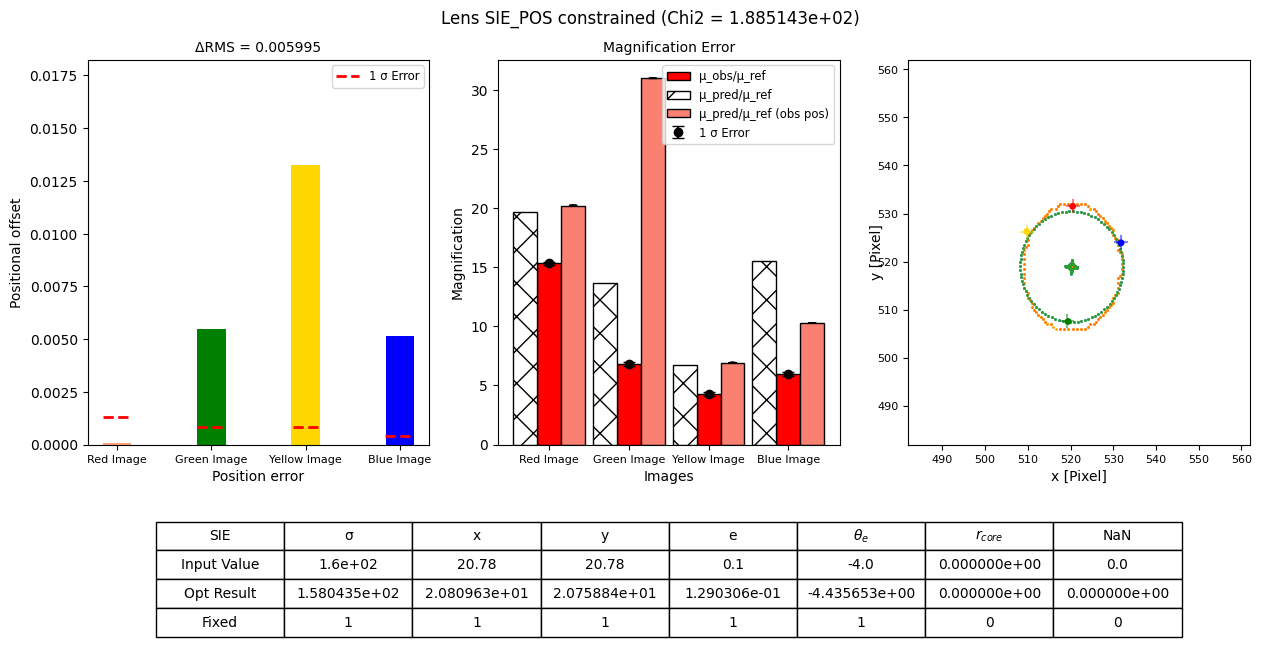

In [193]:
plot_name_1 = 'SIE_POS'
loc = 'SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point_SIE(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [194]:
%run SIE/pos_flux_point.py

amoeba_delta = 1.087631e-01

amoeba_delta = 1.603807e-02

n_img = 4
x =   20.7646   y =   20.3040   mag =   -6.7693 [  -2.076]   td[day] =     1.037
x =   21.2761   y =   20.9603   mag =   13.7240 [  -2.844]   td[day] =     0.000
x =   20.3931   y =   21.0453   mag =   15.5843 [  -2.982]   td[day] =     0.056
x =   20.8199   y =   21.2595   mag =  -19.7335 [  -3.238]   td[day] =     0.168


######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.196427e+04  tol = 1.068904e+00
amoeba:  n =     2  y = 1.098505e+04  tol = 6.382606e-01
amoeba:  n =     3  y = 1.098505e+04  tol = 5.433061e-01
amoeba:  n =     4  y = 7.228478e+03  tol = 7.731550e-01
amoeba:  n =     5  y = 7.228478e+03  tol = 7.074280e-01
amoeba:  n =     6  y = 6.040437e+03  tol = 7.174841e-01
amoeba:  n =     7  y = 5.943001e+03  tol = 6.724944e-01
amoeba:  n =     8  y = 4.940867e+03  tol = 7.970697e-01
amoeba:  n =     9  y = 4.940867e+03  tol = 7.590373e-01
amoeba:  n =    10  y = 4.940867e+03  tol = 3.759630e-01
amoeba:  n =    11  y = 4.810411e+03  tol = 2.267151e-01
amoeba:  n =    12  y = 4.810411e+03  tol = 2.106475e-01
amoeba:  n =    13  y = 4.343976e+03  tol = 3.009776e-01
amoeba:  n =    14  y = 4.334384e+03  tol = 2.808262e-01
amoeba:  n =    15  y = 4.090348e+03  tol = 3.217285e-01
amoeba:  n =    16  y = 4.090348e+03  tol = 1.883509e-01
amo

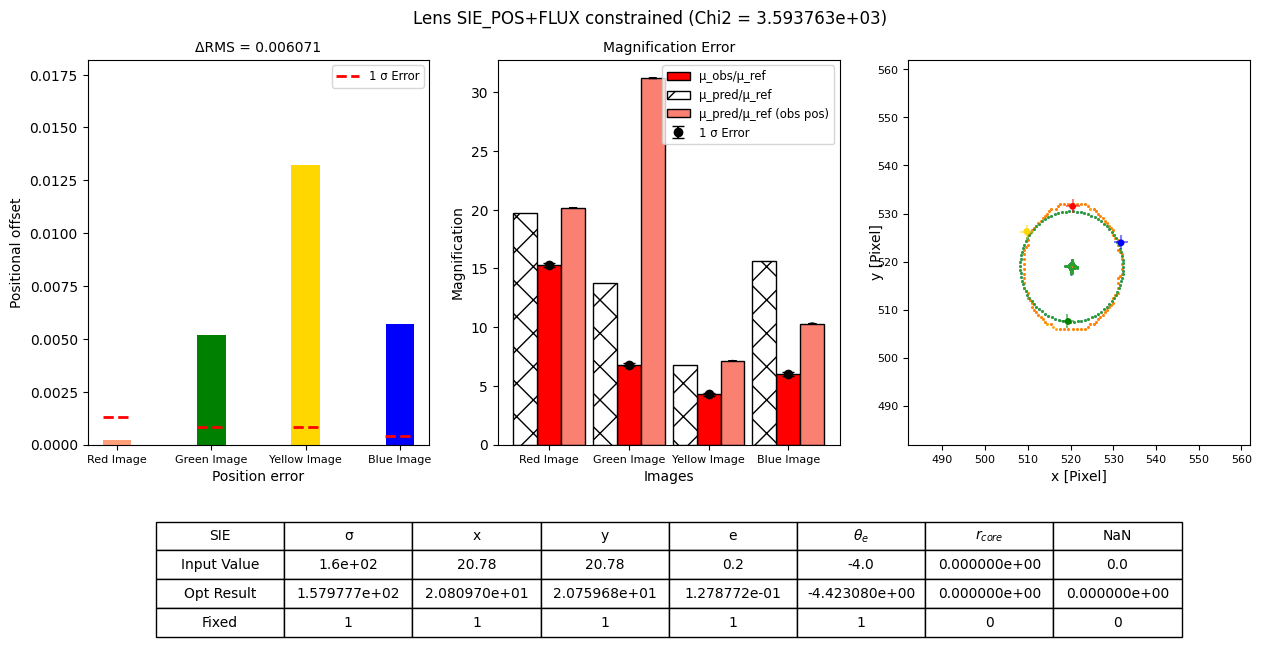

In [195]:
plot_name_1 = 'SIE_POS+FLUX'
loc = 'SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [196]:
# POW Lens Model
%run POW/pos_point.py

######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 8.357616e+05  tol = 1.808312e+00
amoeba:  n =     2  y = 8.357616e+05  tol = 1.794609e+00
amoeba:  n =     3  y = 8.357616e+05  tol = 1.651432e+00
amoeba:  n =     4  y = 5.628399e+05  tol = 1.733860e+00
amoeba:  n =     5  y = 3.696513e+05  tol = 1.811668e+00
amoeba:  n =     6  y = 3.696513e+05  tol = 1.805474e+00
amoeba:  n =     7  y = 3.696513e+05  tol = 1.553558e+00
amoeba:  n =     8  y = 3.696513e+05  tol = 1.304778e+00
amoeba:  n =     9  y = 3.696513e+05  tol = 8.987541e-01
amoeba:  n =    10  y = 3.487207e+05  tol = 8.223693e-01
amoeba:  n =    11  y = 3.487207e+05  tol = 6.875727e-01
amoeba:  n =    12  y = 3.049950e+05  tol = 5.942258e-01
amoeba:  n =    13  y = 2.953094e+05  tol = 3.712068e-01
amoeba:  n =    14  y = 2.953094e+05  tol = 3.404408e-01
amoeba:  n =    15  y = 2.478786e+05  tol = 3.943862e-01
amoeba:  n =    16  y = 1.249656e+05  tol = 9.447397e-01
amo

amoeba_delta = 1.000000e+00

amoeba_delta = 1.585618e-02

n_img = 4
x =   20.7645   y =   20.3032   mag =   -9.2824 [  -2.419]   td[day] =     0.861
x =   21.2761   y =   20.9607   mag =   18.4000 [  -3.162]   td[day] =     0.000
x =   20.3933   y =   21.0459   mag =   20.9244 [  -3.302]   td[day] =     0.045
x =   20.8199   y =   21.2593   mag =  -27.0990 [  -3.582]   td[day] =     0.136


a:  n =    36  y = 2.384183e+04  tol = 1.165170e+00
amoeba:  n =    37  y = 2.384183e+04  tol = 1.002234e+00
amoeba:  n =    38  y = 2.384183e+04  tol = 6.438970e-01
amoeba:  n =    39  y = 2.384183e+04  tol = 3.603232e-01
amoeba:  n =    40  y = 1.423220e+04  tol = 8.111703e-01
amoeba:  n =    41  y = 1.423220e+04  tol = 7.963363e-01
amoeba:  n =    42  y = 1.069367e+04  tol = 1.014082e+00
amoeba:  n =    43  y = 1.069367e+04  tol = 8.926700e-01
amoeba:  n =    44  y = 1.069367e+04  tol = 7.614287e-01
amoeba:  n =    45  y = 1.069367e+04  tol = 2.934681e-01
amoeba:  n =    46  y = 9.916066e+03  tol = 3.638610e-01
amoeba:  n =    47  y = 9.617495e+03  tol = 3.869823e-01
amoeba:  n =    48  y = 8.427281e+03  tol = 3.149021e-01
amoeba:  n =    49  y = 7.943132e+03  tol = 3.671043e-01
amoeba:  n =    50  y = 7.943132e+03  tol = 2.951725e-01
amoeba:  n =    51  y = 7.724313e+03  tol = 2.484927e-01
amoeba:  n =    52  y = 7.361771e+03  tol = 2.657034e-01
amoeba:  n =    53  y = 6.140305e+03

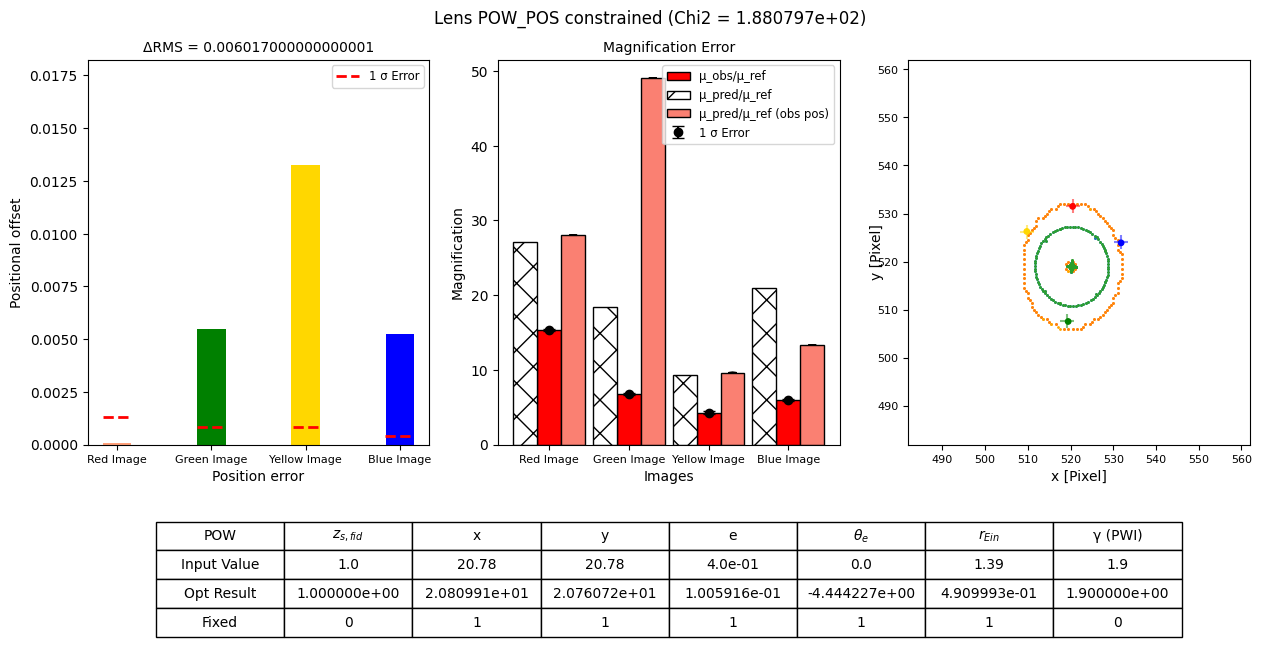

In [197]:
plot_name_1 = 'POW_POS'
loc = 'POW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [198]:
# POW Lens Model
%run POW/pos_flux_point.py

amoeba_delta = 2.829026e-01

amoeba_delta = 1.583918e-02

n_img = 4
x =   20.7646   y =   20.3036   mag =  -13.4616 [  -2.823]   td[day] =     0.679
x =   21.2759   y =   20.9601   mag =   25.9297 [  -3.534]   td[day] =     0.000
x =   20.3935   y =   21.0453   mag =   29.5230 [  -3.675]   td[day] =     0.036
x =   20.8199   y =   21.2595   mag =  -38.8420 [  -3.973]   td[day] =     0.108


######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 5.537360e+04  tol = 6.844235e-01
amoeba:  n =     2  y = 5.470705e+04  tol = 3.739430e-01
amoeba:  n =     3  y = 4.318237e+04  tol = 4.463008e-01
amoeba:  n =     4  y = 3.961242e+04  tol = 4.680036e-01
amoeba:  n =     5  y = 3.961242e+04  tol = 3.420416e-01
amoeba:  n =     6  y = 2.639144e+04  tol = 7.089132e-01
amoeba:  n =     7  y = 2.639144e+04  tol = 6.983016e-01
amoeba:  n =     8  y = 2.639144e+04  tol = 5.447621e-01
amoeba:  n =     9  y = 2.639144e+04  tol = 4.826795e-01
amoeba:  n =    10  y = 2.639144e+04  tol = 4.006122e-01
amoeba:  n =    11  y = 2.586589e+04  tol = 2.329817e-01
amoeba:  n =    12  y = 2.586589e+04  tol = 1.981257e-01
amoeba:  n =    13  y = 2.528793e+04  tol = 1.468769e-01
amoeba:  n =    14  y = 1.957573e+04  tol = 3.512427e-01
amoeba:  n =    15  y = 1.957573e+04  tol = 3.119261e-01
amoeba:  n =    16  y = 1.957573e+04  tol = 2.965470e-01
amo

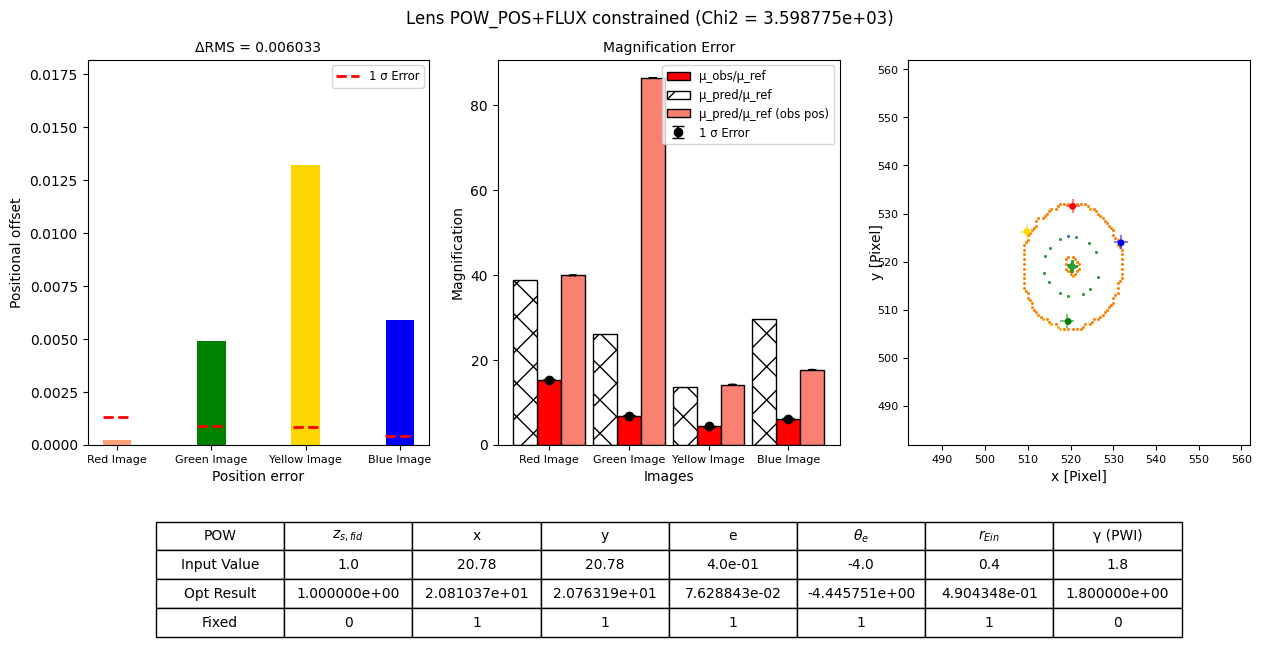

In [199]:
plot_name_1 = 'POW_POS+FLUX'
loc = 'POW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [115]:
# NFW Lens Model
%run NFW/pos_point.py

amoeba_delta = 3.611725e-01

amoeba_delta = 1.581059e-02

n_img = 5
x =   20.7645   y =   20.3033   mag =  -34.2411 [  -3.836]   td[day] =     0.416
x =   20.8101   y =   20.7615   mag =    0.1294 [   2.220]   td[day] =     1.633
x =   21.2761   y =   20.9607   mag =   61.3539 [  -4.470]   td[day] =     0.000
x =   20.3932   y =   21.0460   mag =   70.0767 [  -4.614]   td[day] =     0.021
x =   20.8199   y =   21.2593   mag =  -95.6059 [  -4.951]   td[day] =     0.065


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.310279e+05  tol = 1.158883e+00
amoeba:  n =     2  y = 8.846286e+04  tol = 1.259321e+00
amoeba:  n =     3  y = 8.846286e+04  tol = 1.187664e+00
amoeba:  n =     4  y = 8.846286e+04  tol = 9.429062e-01
amoeba:  n =     5  y = 8.846286e+04  tol = 9.088300e-01
amoeba:  n =     6  y = 8.846286e+04  tol = 8.302714e-01
amoeba:  n =     7  y = 8.846286e+04  tol = 7.651895e-01
amoeba:  n =     8  y = 8.846286e+04  tol = 6.913937e-01
amoeba:  n =     9  y = 8.846286e+04  tol = 3.878525e-01
amoeba:  n =    10  y = 8.846286e+04  tol = 3.875511e-01
amoeba:  n =    11  y = 7.547086e+04  tol = 5.148676e-01
amoeba:  n =    12  y = 7.547086e+04  tol = 4.837586e-01
amoeba:  n =    13  y = 7.547086e+04  tol = 4.639320e-01
amoeba:  n =    14  y = 7.547086e+04  tol = 4.198463e-01
amoeba:  n =    15  y = 7.547086e+04  tol = 4.024790e-01
amoeba:  n =    16  y = 7.436517e+04  tol = 3.324843e-01
amo

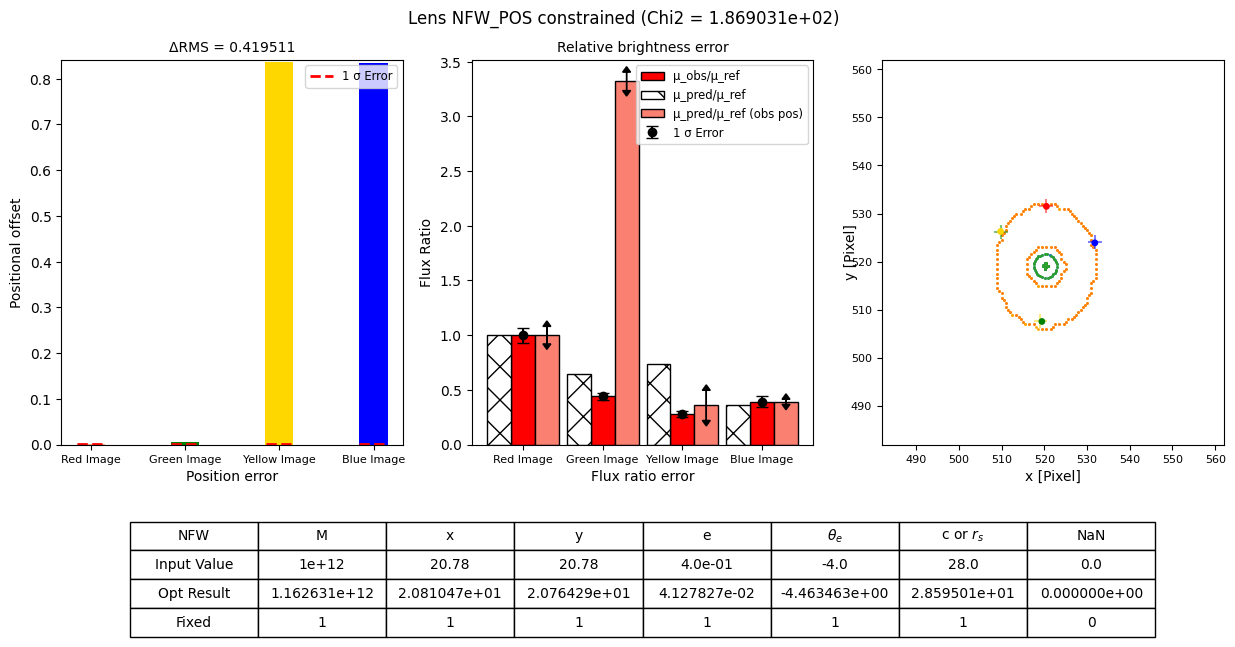

In [116]:
plot_name_1 = 'NFW_POS'
loc = 'NFW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [79]:
# NFW Lens Model
%run NFW/pos_flux_point.py

amoeba_delta = 3.586417e-01

amoeba_delta = 1.121238e-02

amoeba_delta = 1.118750e-02

n_img = 5
x =    2.4493   y =    1.9836   mag =  -34.9184 [  -3.858]   td[day] =     0.389
x =    2.4915   y =    2.4431   mag =    0.1098 [   2.399]   td[day] =     1.675
x =    2.9520   y =    2.6450   mag =   63.2681 [  -4.503]   td[day] =     0.000
x =    2.0761   y =    2.7233   mag =   71.3917 [  -4.634]   td[day] =     0.018
x =    2.5012   y =    2.9382   mag =  -98.1011 [  -4.979]   td[day] =     0.059


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 2.664380e+05  tol = 6.108359e-01
amoeba:  n =     2  y = 2.664380e+05  tol = 5.898087e-01
amoeba:  n =     3  y = 2.069612e+05  tol = 7.702457e-01
amoeba:  n =     4  y = 2.069612e+05  tol = 5.918102e-01
amoeba:  n =     5  y = 2.069612e+05  tol = 5.234252e-01
amoeba:  n =     6  y = 2.069612e+05  tol = 4.736481e-01
amoeba:  n =     7  y = 2.069612e+05  tol = 3.646679e-01
amoeba:  n =     8  y = 2.069612e+05  tol = 3.087965e-01
amoeba:  n =     9  y = 1.267406e+05  tol = 7.543712e-01
amoeba:  n =    10  y = 1.267406e+05  tol = 7.230388e-01
amoeba:  n =    11  y = 1.267406e+05  tol = 7.106054e-01
amoeba:  n =    12  y = 1.267406e+05  tol = 6.158315e-01
amoeba:  n =    13  y = 1.267406e+05  tol = 5.570561e-01
amoeba:  n =    14  y = 1.128021e+05  tol = 5.889303e-01
amoeba:  n =    15  y = 8.763701e+04  tol = 7.958496e-01
amoeba:  n =    16  y = 8.763701e+04  tol = 7.770067e-01
amo

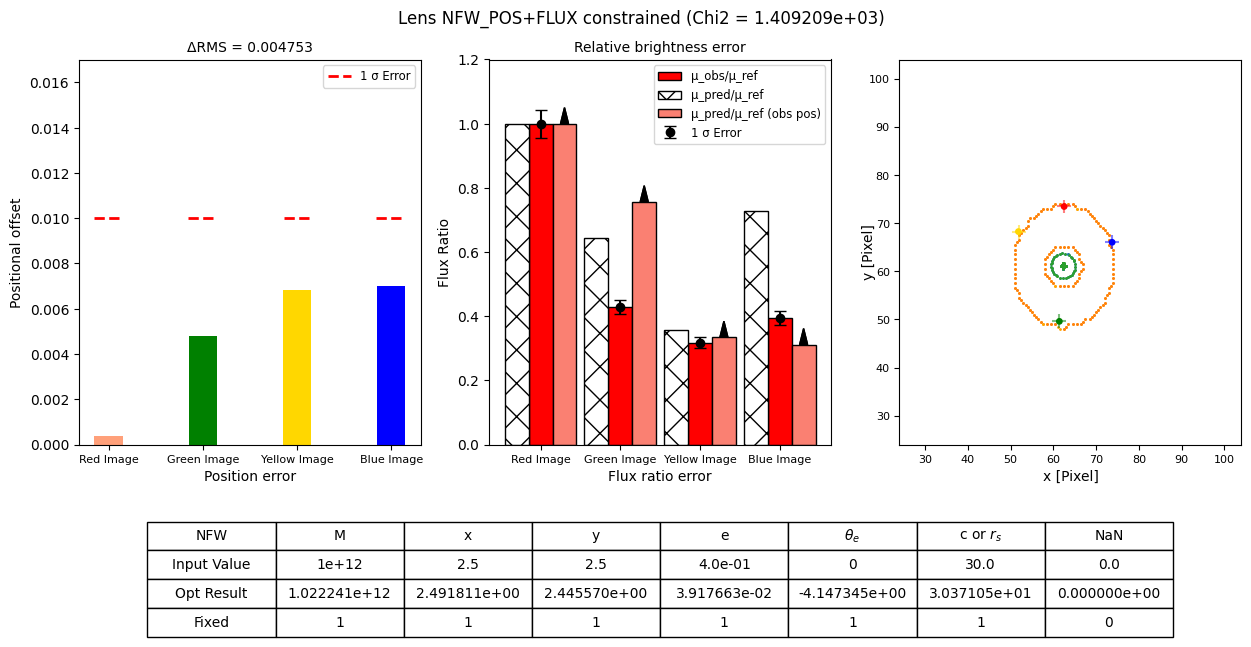

In [80]:
plot_name_1 = 'NFW_POS+FLUX'
loc = 'NFW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [89]:
# Core SIE
%run C_SIE/pos_point.py

amoeba_delta = 1.000000e+00

amoeba_delta = 1.073618e-01

amoeba_delta = 1.126160e-02

n_img = 5
x =    2.4493   y =    1.9840   mag =   -8.8628 [  -2.369]   td[day] =     0.873
x =    2.4910   y =    2.4375   mag =    0.0275 [   3.901]   td[day] =     3.804
x =    2.9527   y =    2.6448   mag =   17.6581 [  -3.117]   td[day] =     0.000
x =    2.0763   y =    2.7236   mag =   19.9005 [  -3.247]   td[day] =     0.042
x =    2.5009   y =    2.9381   mag =  -25.9155 [  -3.534]   td[day] =     0.135


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 9.519261e+05  tol = 2.000000e+00
amoeba:  n =     2  y = 9.519261e+05  tol = 2.000000e+00
amoeba:  n =     3  y = 9.519261e+05  tol = 2.000000e+00
amoeba:  n =     4  y = 9.519261e+05  tol = 2.000000e+00
amoeba:  n =     5  y = 9.519261e+05  tol = 2.000000e+00
amoeba:  n =     6  y = 9.519261e+05  tol = 1.889367e+00
amoeba:  n =     7  y = 9.519261e+05  tol = 1.774262e+00
amoeba:  n =     8  y = 9.519261e+05  tol = 1.745731e+00
amoeba:  n =     9  y = 9.519261e+05  tol = 1.731723e+00
amoeba:  n =    10  y = 6.724600e+05  tol = 1.734422e+00
amoeba:  n =    11  y = 6.724600e+05  tol = 1.708729e+00
amoeba:  n =    12  y = 6.724600e+05  tol = 1.681508e+00
amoeba:  n =    13  y = 6.724600e+05  tol = 1.637458e+00
amoeba:  n =    14  y = 6.724600e+05  tol = 1.521778e+00
amoeba:  n =    15  y = 3.150305e+05  tol = 1.718312e+00
amoeba:  n =    16  y = 3.150305e+05  tol = 1.712164e+00
amo

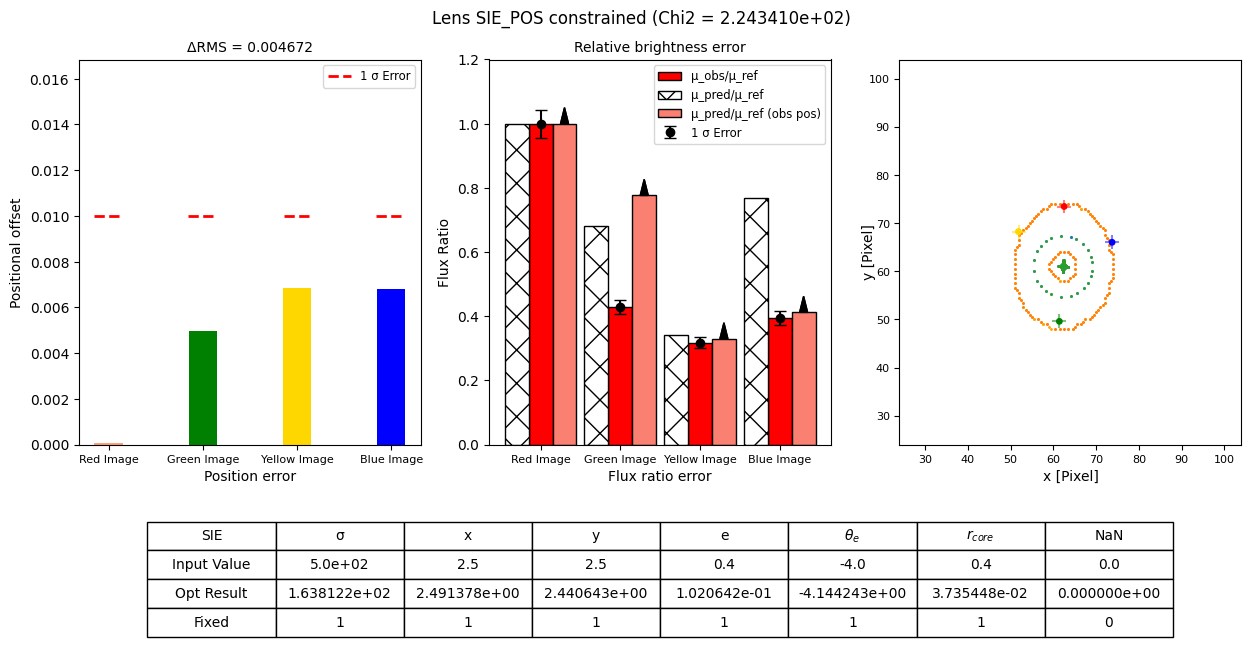

In [90]:
plot_name_1 = 'SIE_POS'
loc = 'C_SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [93]:
%run C_SIE/pos_flux_point.py

amoeba_delta = 7.807599e-01



######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 7.831211e+05  tol = 2.000000e+00
amoeba:  n =     2  y = 7.831211e+05  tol = 2.000000e+00
amoeba:  n =     3  y = 7.831211e+05  tol = 2.000000e+00
amoeba:  n =     4  y = 7.831211e+05  tol = 2.000000e+00
amoeba:  n =     5  y = 7.831211e+05  tol = 2.000000e+00
amoeba:  n =     6  y = 7.831211e+05  tol = 2.214700e-01
amoeba:  n =     7  y = 7.183914e+05  tol = 2.314547e-01
amoeba:  n =     8  y = 7.183914e+05  tol = 2.162903e-01
amoeba:  n =     9  y = 7.170821e+05  tol = 2.033576e-01
amoeba:  n =    10  y = 6.498103e+05  tol = 2.971418e-01
amoeba:  n =    11  y = 5.985986e+05  tol = 2.670910e-01
amoeba:  n =    12  y = 5.985986e+05  tol = 2.256093e-01
amoeba:  n =    13  y = 5.985986e+05  tol = 1.819191e-01
amoeba:  n =    14  y = 5.939624e+05  tol = 1.878192e-01
amoeba:  n =    15  y = 5.939624e+05  tol = 8.980400e-02
amoeba:  n =    16  y = 5.939624e+05  tol = 5.263862e-02
amo

amoeba_delta = 5.012547e-01

amoeba_delta = 1.124558e-02

n_img = 5
x =    2.4492   y =    1.9844   mag =  -89.1200 [  -4.875]   td[day] =     0.249
x =    2.4893   y =    2.4270   mag =   12.0386 [  -2.701]   td[day] =     0.721
x =    2.9527   y =    2.6455   mag =  149.7216 [  -5.438]   td[day] =     0.000
x =    2.0751   y =    2.7239   mag =  169.2889 [  -5.572]   td[day] =     0.011
x =    2.5011   y =    2.9377   mag = -239.0664 [  -5.946]   td[day] =     0.037


642e+05  tol = 3.711347e-01
amoeba:  n =    16  y = 2.453642e+05  tol = 2.880354e-01
amoeba:  n =    17  y = 2.453642e+05  tol = 2.015124e-01
amoeba:  n =    18  y = 2.453642e+05  tol = 1.873707e-01
amoeba:  n =    19  y = 2.453642e+05  tol = 1.799706e-01
amoeba:  n =    20  y = 2.453642e+05  tol = 1.647023e-01
amoeba:  n =    21  y = 2.445203e+05  tol = 1.485189e-01
amoeba:  n =    22  y = 2.425337e+05  tol = 7.655520e-02
amoeba:  n =    23  y = 2.297758e+05  tol = 7.427831e-02
amoeba:  n =    24  y = 2.297758e+05  tol = 7.255938e-02
amoeba:  n =    25  y = 2.297758e+05  tol = 6.561602e-02
amoeba:  n =    26  y = 2.182858e+05  tol = 1.133713e-01
amoeba:  n =    27  y = 2.182858e+05  tol = 1.052381e-01
amoeba:  n =    28  y = 2.169406e+05  tol = 8.631739e-02
amoeba:  n =    29  y = 2.169406e+05  tol = 8.258839e-02
amoeba:  n =    30  y = 2.089438e+05  tol = 9.496735e-02
amoeba:  n =    31  y = 2.045591e+05  tol = 1.155271e-01
amoeba:  n =    32  y = 2.045591e+05  tol = 6.492583e-02
amo

moeba:  n =     4  y = 1.258029e+03  tol = 1.230796e-01
amoeba:  n =     5  y = 1.258029e+03  tol = 1.072151e-01
amoeba:  n =     6  y = 1.258029e+03  tol = 9.663077e-02
amoeba:  n =     7  y = 1.258029e+03  tol = 4.411882e-02
amoeba:  n =     8  y = 1.258029e+03  tol = 4.408923e-02
amoeba:  n =     9  y = 1.258029e+03  tol = 3.971472e-02
amoeba:  n =    10  y = 1.258029e+03  tol = 3.804472e-02
amoeba:  n =    11  y = 1.258029e+03  tol = 3.644691e-02
amoeba:  n =    12  y = 1.258029e+03  tol = 3.469163e-02
amoeba:  n =    13  y = 1.258029e+03  tol = 3.182482e-02
amoeba:  n =    14  y = 1.258029e+03  tol = 1.697096e-02
amoeba:  n =    15  y = 1.258029e+03  tol = 1.540868e-02
amoeba:  n =    16  y = 1.258029e+03  tol = 1.535478e-02
amoeba:  n =    17  y = 1.258029e+03  tol = 1.388893e-02
amoeba:  n =    18  y = 1.258029e+03  tol = 1.149706e-02
amoeba:  n =    19  y = 1.258029e+03  tol = 1.102113e-02
amoeba:  n =    20  y = 1.258029e+03  tol = 5.093896e-03
amoeba:  n =    21  y = 1.258029

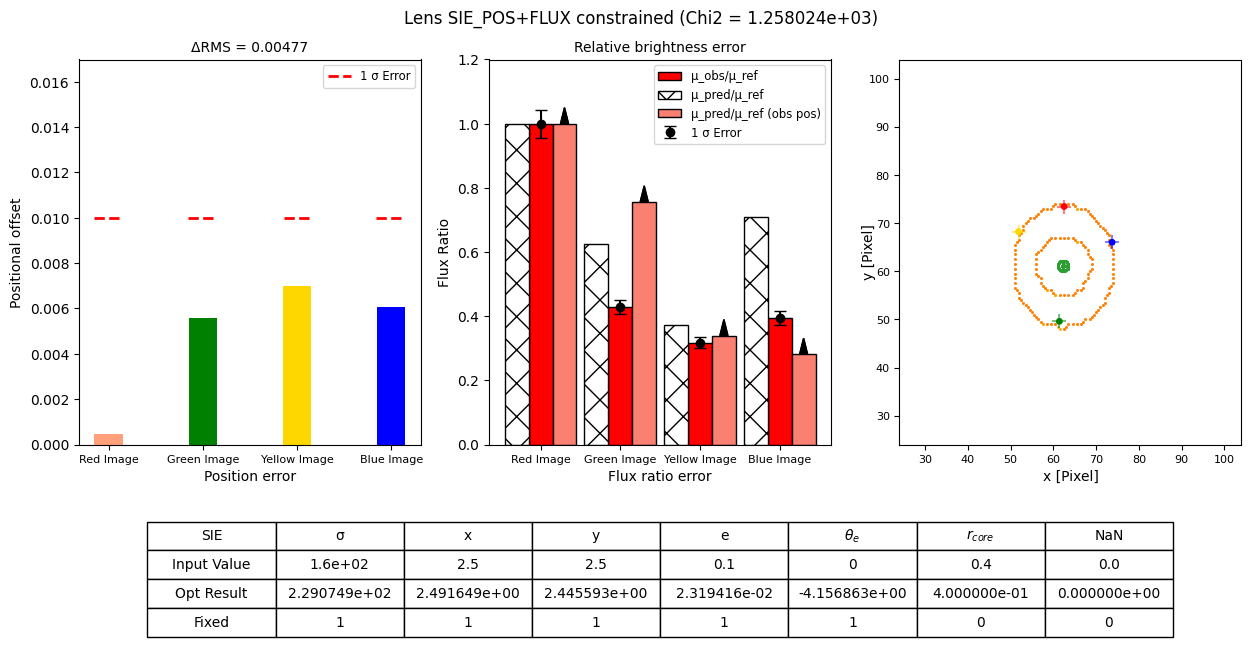

In [94]:
plot_name_1 = 'SIE_POS+FLUX'
loc = 'C_SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)